In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

In [3]:
df = pd.read_csv('results.csv')
df['problem'] = df['problem'].str.replace(r'_?Results', '', regex=True)
df['model'] = df['model'].replace({'chat-bison@001': 'PaLM 2', 
                                   'claude-2': 'Claude 2',
                                   'claude-instant-1.2': 'Claude Instant',
                                   'gpt-3.5-turbo': 'GPT 3.5',
                                   'gpt-4-1106-preview': 'GPT 4',
                                   'mistral': 'Mistral',
                                   'mpt': 'MPT',
                                   'phi': 'Phi',
                                   'vicuna': 'Vicuna',
                                   'yi': 'Yi'})
df.head(10)

model problem   level  Average accuracy  Failure  weighted_accuracy  \
0  Vicuna   gcp_d   Lvl 1               0.0      0.9           0.000000   
1  Vicuna   gcp_d   Lvl 2               0.0      0.9           0.000000   
2  Vicuna   gcp_d   Lvl 3               0.2      0.5           0.010909   
3  Vicuna   gcp_d   Lvl 4               0.1      0.4           0.007273   
4  Vicuna   gcp_d   Lvl 5               0.2      0.5           0.018182   
5  Vicuna   gcp_d   Lvl 6               0.2      0.5           0.021818   
6  Vicuna   gcp_d   Lvl 7               0.6      0.0           0.076364   
7  Vicuna   gcp_d   Lvl 8               0.5      0.1           0.072727   
8  Vicuna   gcp_d   Lvl 9               0.5      0.4           0.081818   
9  Vicuna   gcp_d  Lvl 10               0.3      0.5           0.054545   

   weighted_failed complexity  \
0             0.09     np-cmp   
1             0.09     np-cmp   
2             0.05     np-cmp   
3             0.04     np-cmp   
4             0.05     np-cmp   
5             0.05     np-cmp   
6             0.00     np-cmp   
7             0.01     np-cmp   
8             0.04     np-cmp   
9             0.05     np-cmp   

                                     lvl_correctness  is_close  
0  ['failed', 'failed', 'failed', 'failed', 'fail...     False  
1  [False, 'failed', 'failed', 'failed', 'failed'...     False  
2  [True, False, False, True, False, 'failed', 'f...     False  
3  [False, False, 'failed', True, 'failed', False...     False  
4  [True, 'failed', False, 'failed', True, 'faile...     False  
5  ['failed', False, True, 'failed', 'failed', 'f...     False  
6  [False, True, True, True, False, False, True, ...     False  
7  [True, False, True, True, False, False, True, ...     False  
8  [True, 'failed', 'failed', 'failed', False, Tr...     False  
9  ['failed', True, False, False, 'failed', 'fail...     False

In [65]:
set(df['model'].to_list())

{'Claude 2',
 'Claude Instant',
 'GPT 3.5',
 'GPT 4',
 'MPT',
 'Mistral',
 'PaLM 2',
 'Phi',
 'Vicuna',
 'Yi'}

In [4]:
model_df = df.groupby(['model', 'complexity', 'problem'])['Average accuracy'].agg(list).reset_index()
print(model_df)

       model complexity problem  \
0   Claude 2     np-cmp   gcp_d   
1   Claude 2     np-cmp     ksp   
2   Claude 2     np-cmp   tsp_d   
3   Claude 2    np-hard     gcp   
4   Claude 2    np-hard     msp   
..       ...        ...     ...   
85        Yi    np-hard     msp   
86        Yi    np-hard     tsp   
87        Yi          p     bsp   
88        Yi          p     mfp   
89        Yi          p     spp   

                                     Average accuracy  
0   [0.9, 0.9, 0.8, 0.8, 0.7, 0.6, 0.4, 0.6, 0.3, ...  
1   [0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2   [0.9, 1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.9, 1.0, ...  
3   [0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...  
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
..                                                ...  
85  [0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
86  [0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
87  [0.8, 0.9, 0.8, 0.8, 0.5, 0.5, 0.6, 0.5, 0.8, ...  
88  [0.0, 0.1, 0.2,

In [5]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 500
rcParams['savefig.dpi'] = 500
rcParams['figure.figsize'] = 10,5
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 18

In [ ]:
# model = 'PaLM 2'
# mdf = model_df[model_df['model']==model]
# mdf = mdf.explode('Average accuracy')
# sns.boxplot(x='problem', y='Average accuracy', hue='complexity', data=mdf, gap=.3)

In [22]:
import itertools
from scipy.stats import wilcoxon

colors = {'p': 'steelblue', 'np-cmp': 'darkorange', 'np-hard': 'limegreen'}
complexities = ['p', 'np-cmp', 'np-hard']


def wilcoxon_test(complexity_df, problem_pairs):
    # Perform Wilcoxon test for each pair
    p_values = []
    for pair in problem_pairs:
        problem1 = pair[0]
        problem2 = pair[1]
        pair_df = complexity_df[(complexity_df['problem'] == problem1) | (complexity_df['problem'] == problem2)]
        x = pair_df[pair_df['problem'] == problem1]['Average accuracy']
        y = pair_df[pair_df['problem'] == problem2]['Average accuracy']
        try:
            stat, p_value = wilcoxon(x, y)
        except:
            p_value = 1.0
        p_values.append(p_value)
    return p_values


def annotate_statistics(complexity_df, complexity, problem_pairs, p_values, ax):
    # Annotate the boxplot with the p-values
    offset = 0
    for i, pair in enumerate(problem_pairs):
        problem1 = pair[0]
        problem2 = pair[1]
        x1 = complexity_df[complexity_df['problem'] == problem1]['problem'].index[0]
        x2 = complexity_df[complexity_df['problem'] == problem2]['problem'].index[0]
        y = complexity_df['Average accuracy'].max() + offset
        h = 0.05
        col = colors[complexity]
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        ax.text((x1+x2)*.5, y+h, f"p={p_values[i]:.4f}", ha='center', va='bottom', color=col)
        offset += 0.15


def create_figure(model_df, model):
    # Create a figure for the model
    mdf = model_df[model_df['model']==model]
    mdf = mdf.sort_values(by=['complexity'], key=lambda x: x.map({'p': 0, 'np-cmp': 1, 'np-hard': 2}))
    mdf = mdf.reset_index()
    mdf = mdf.explode('Average accuracy')
    fig, ax = plt.subplots()
    for complexity in complexities:
        complexity_df = mdf[mdf['complexity'] == complexity]
        problems = complexity_df['problem'].unique()
        problem_pairs = list(itertools.combinations(problems, 2))
        p_values = wilcoxon_test(complexity_df, problem_pairs)
        sns.boxplot(x='problem', y='Average accuracy', hue='complexity', data=complexity_df, gap=.3, palette=colors)
        annotate_statistics(complexity_df, complexity, problem_pairs, p_values, ax)
    #ax.legend().remove()
    plt.title(f"Model: {model}")
    yticks = ax.get_yticks()
    ax.set_yticks([tick for tick in yticks if tick <= 1.1])
    plt.ylim(0, 1.5)
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

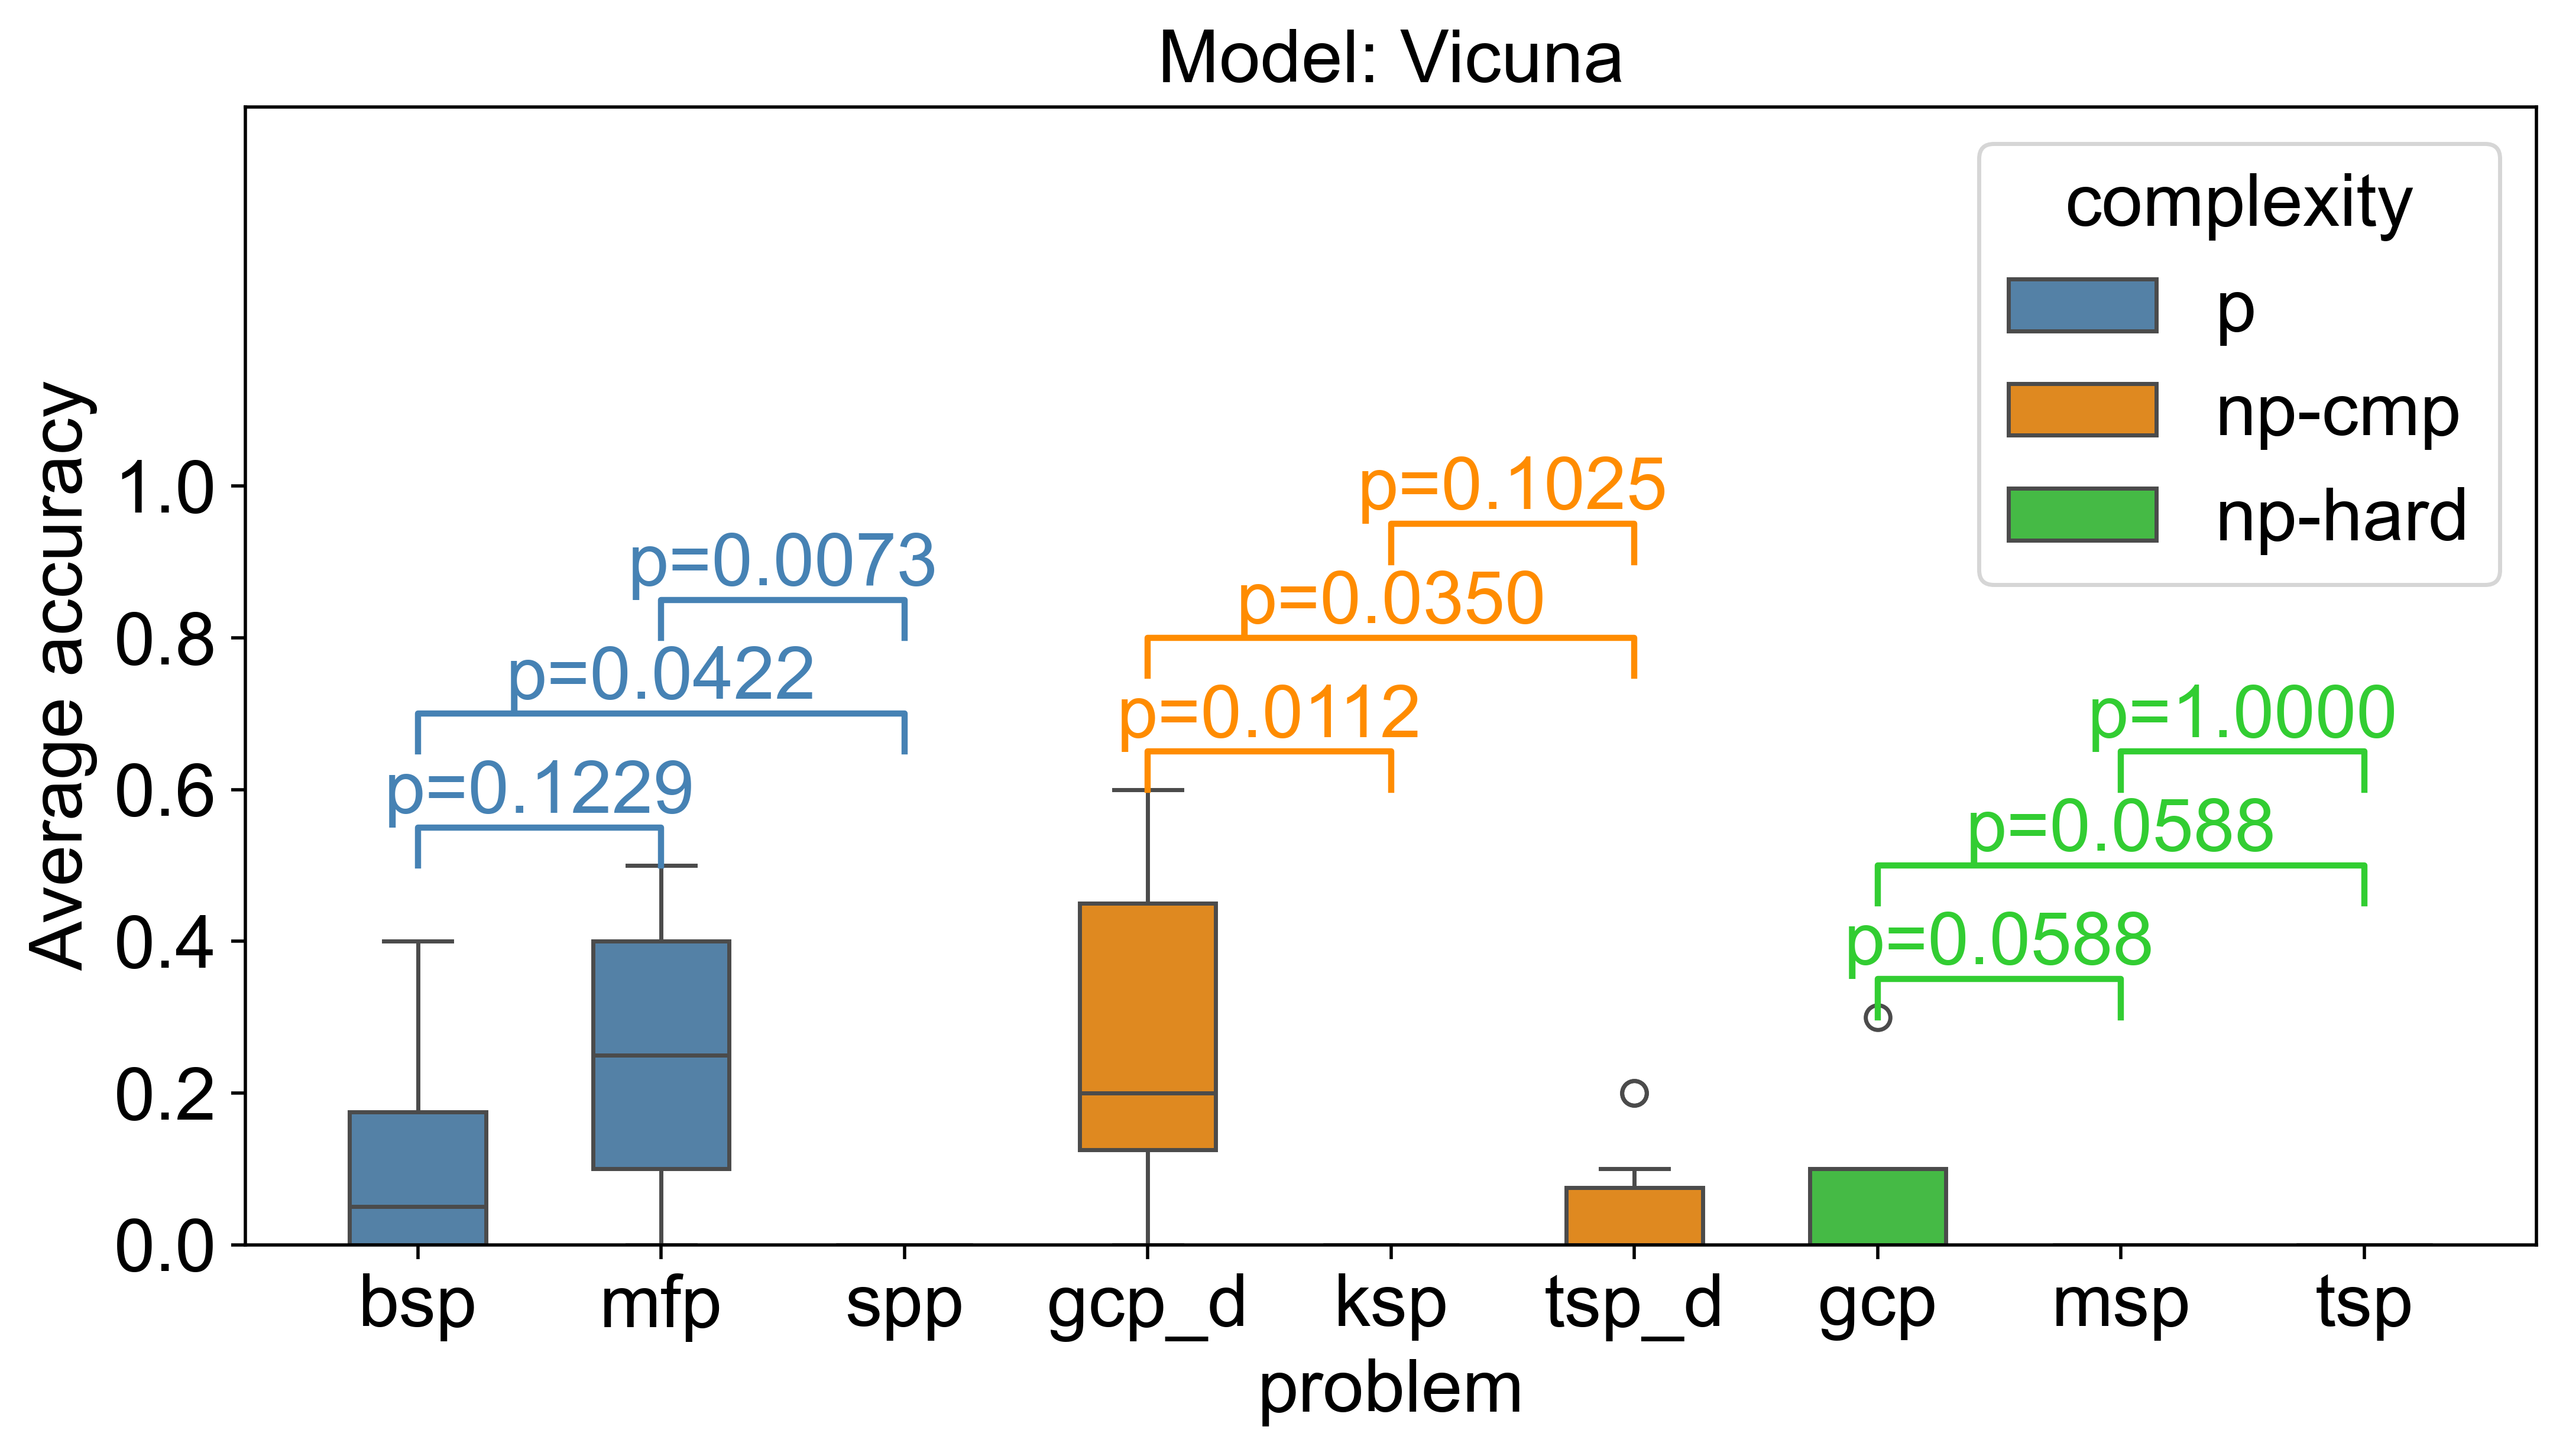

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

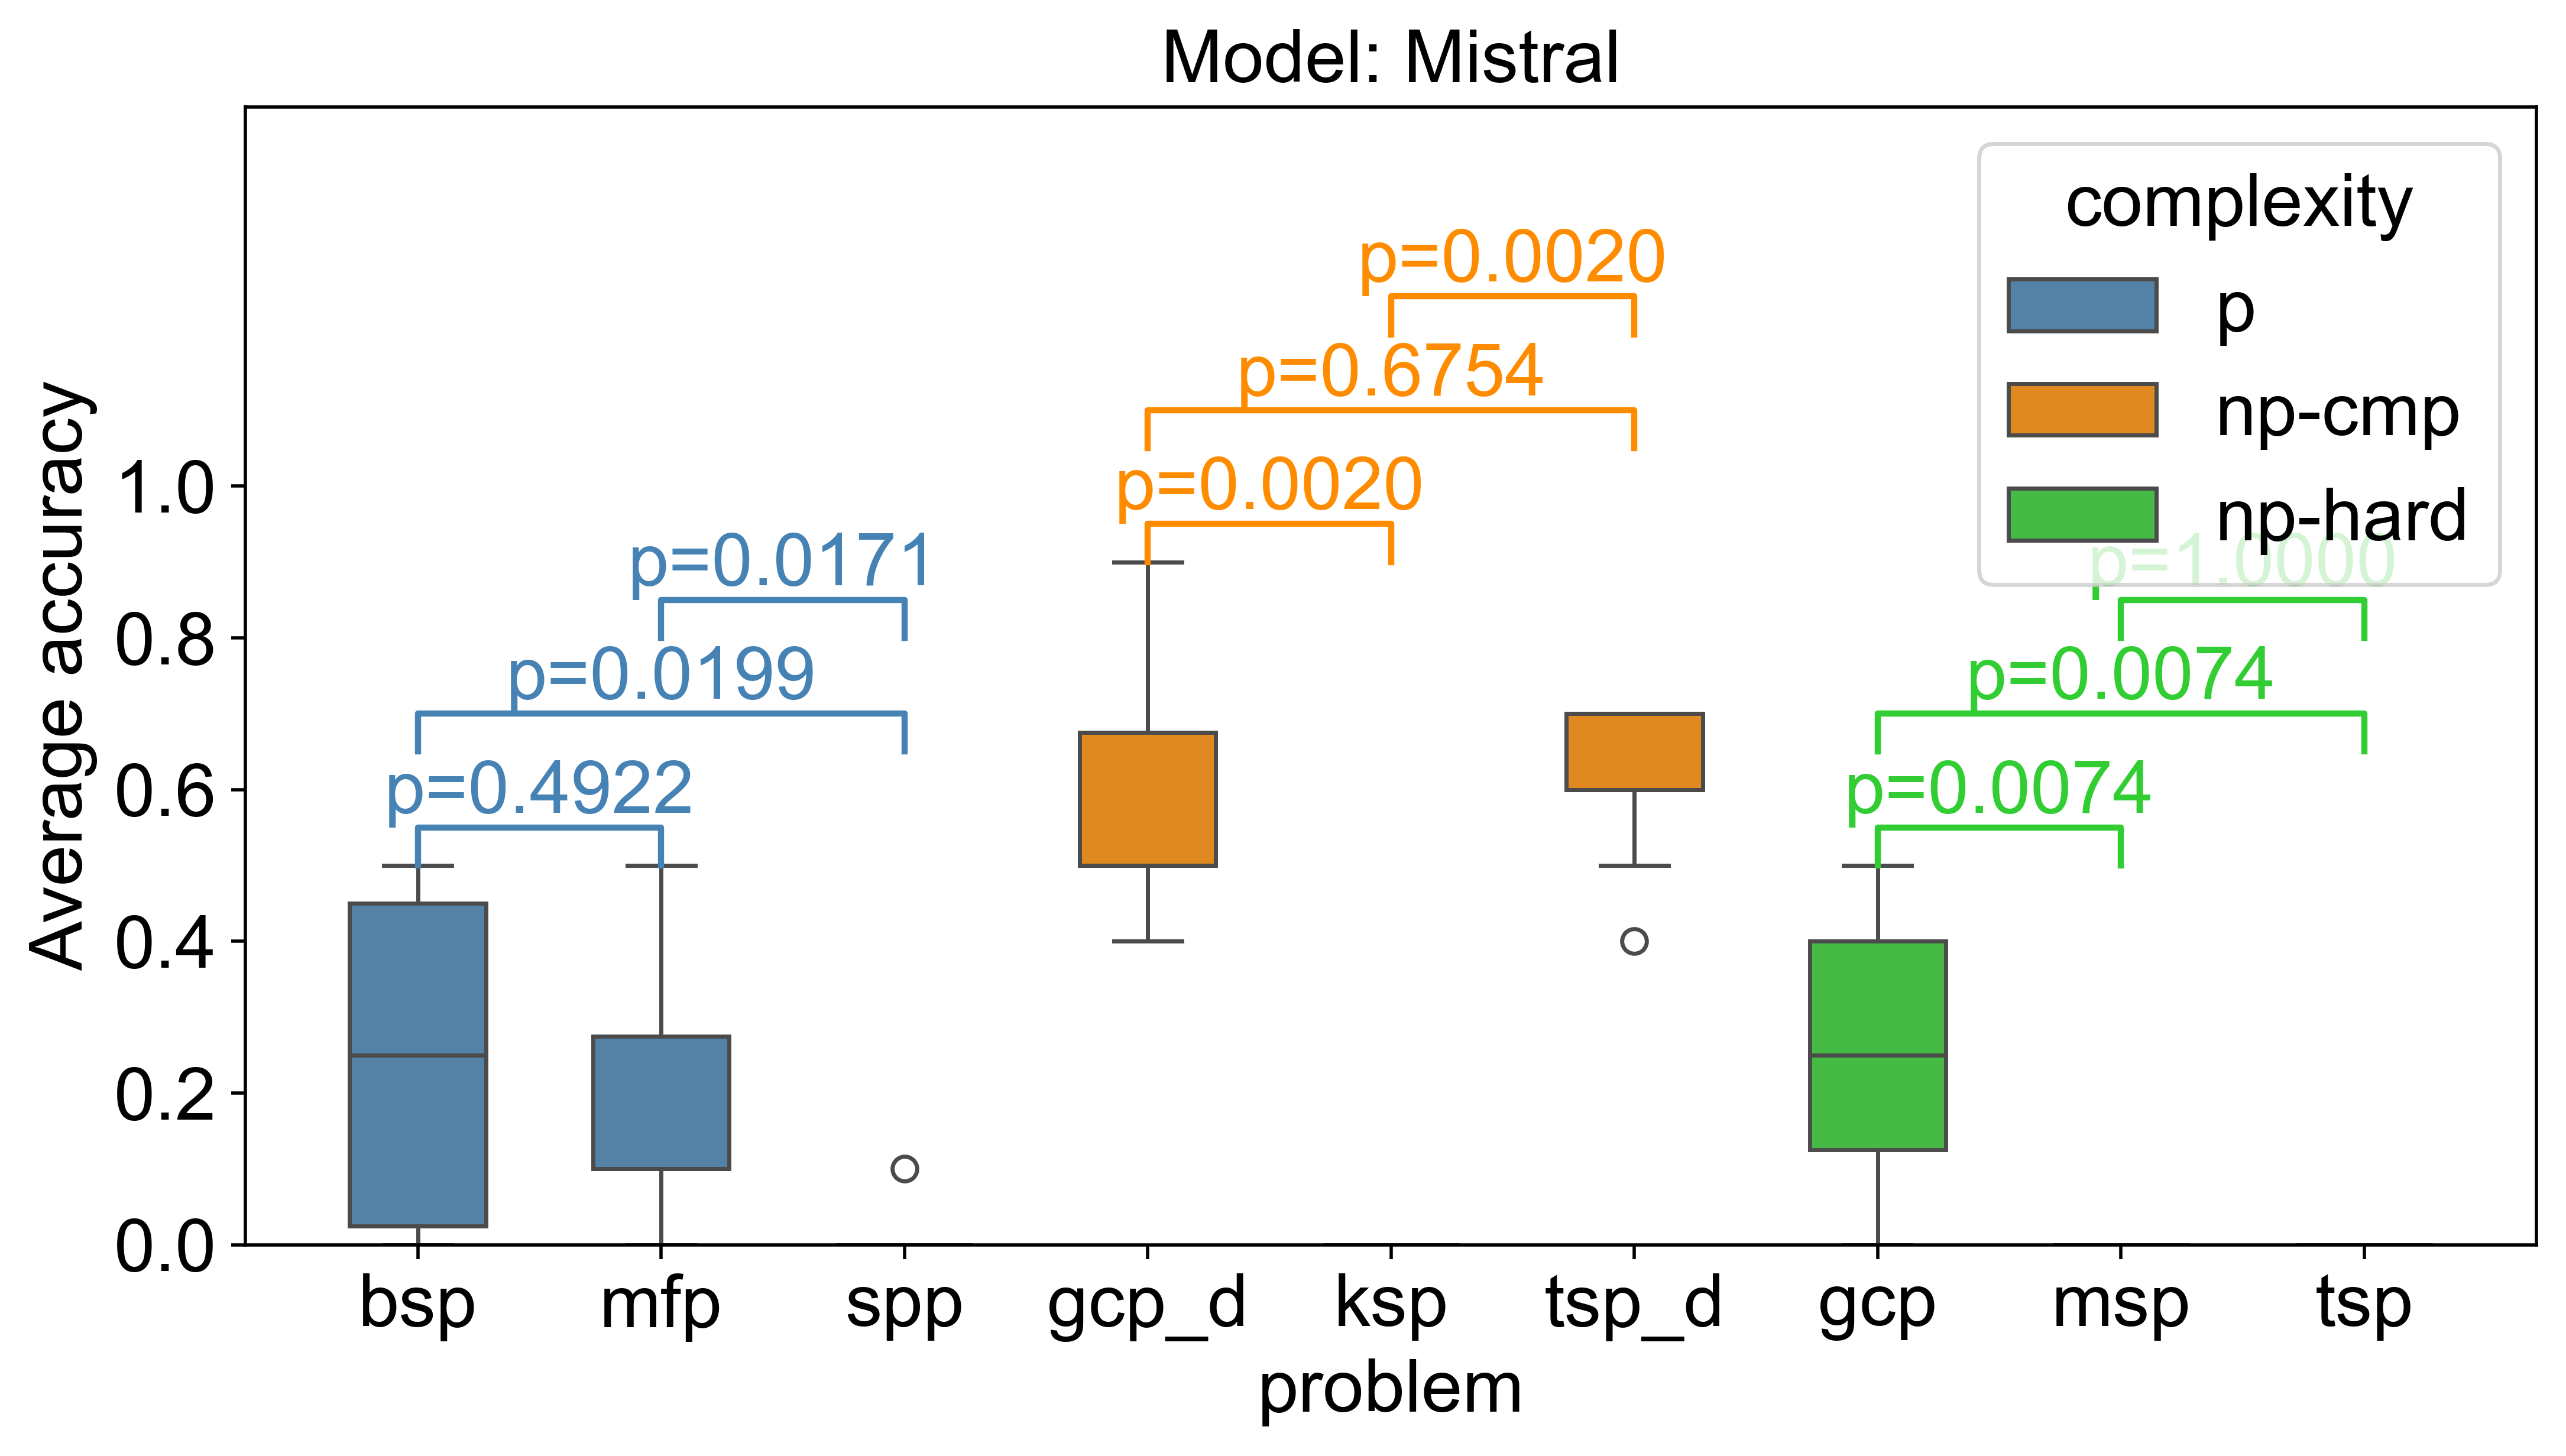

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

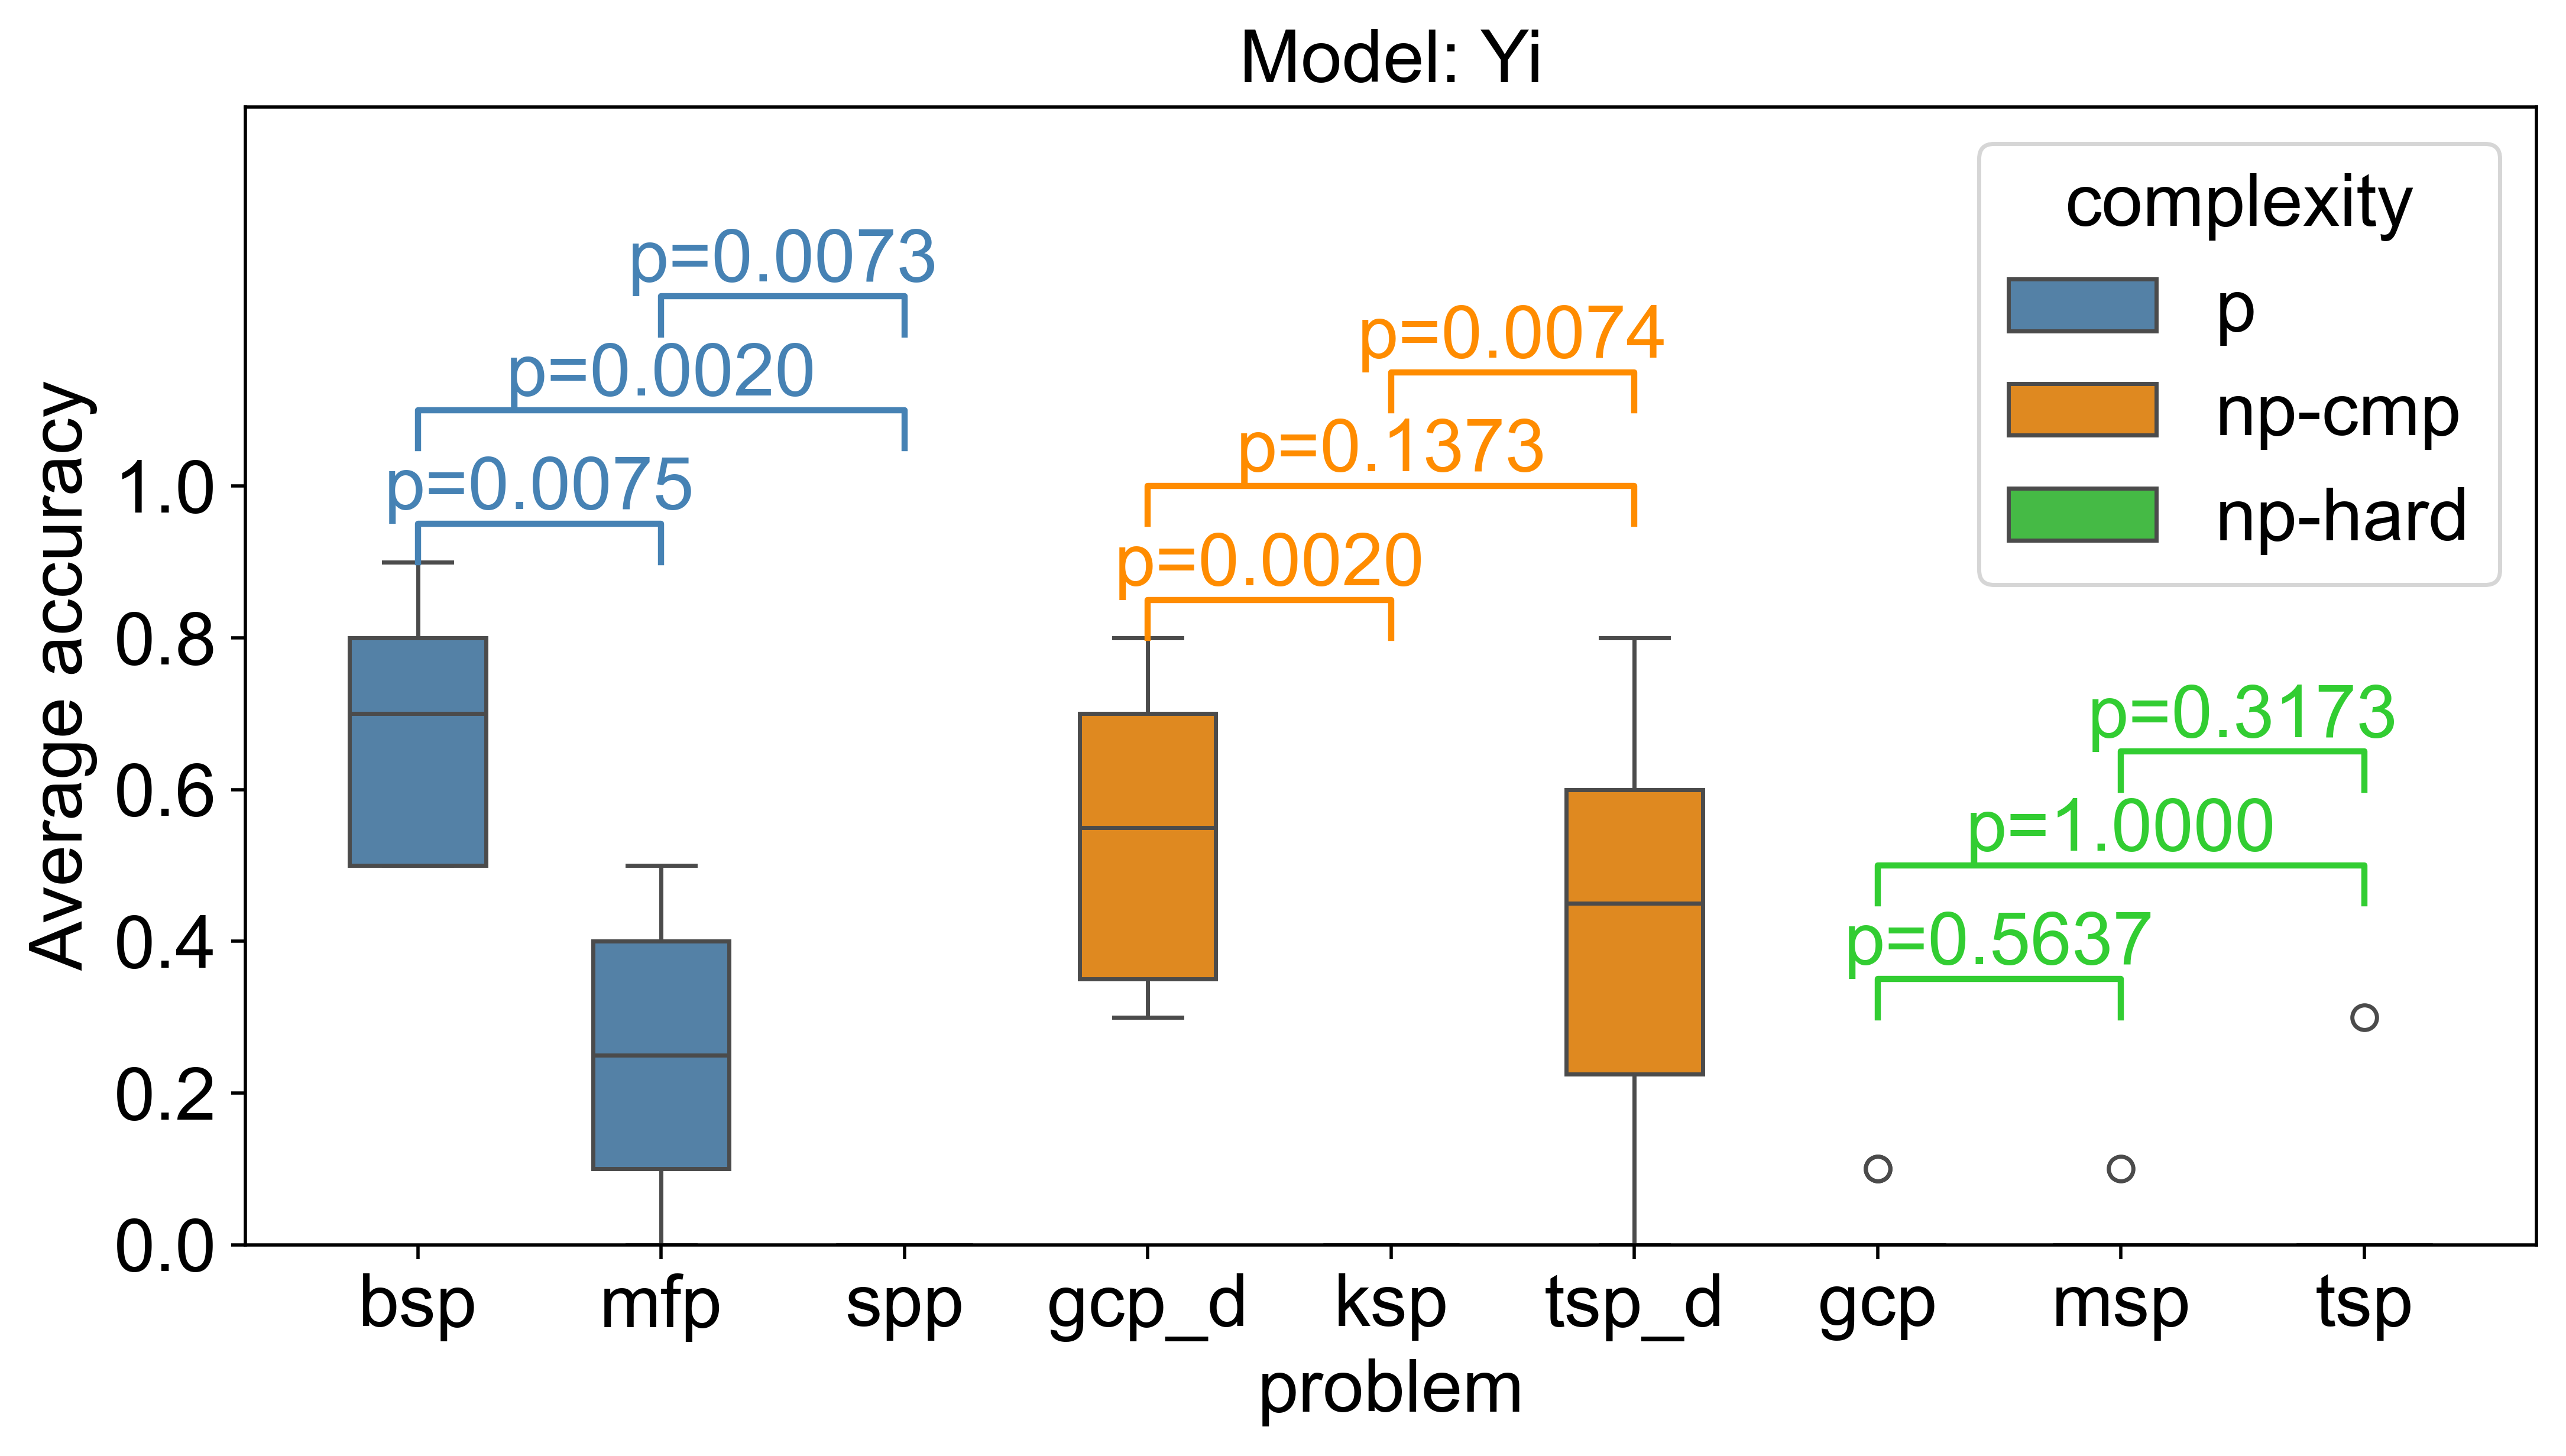

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

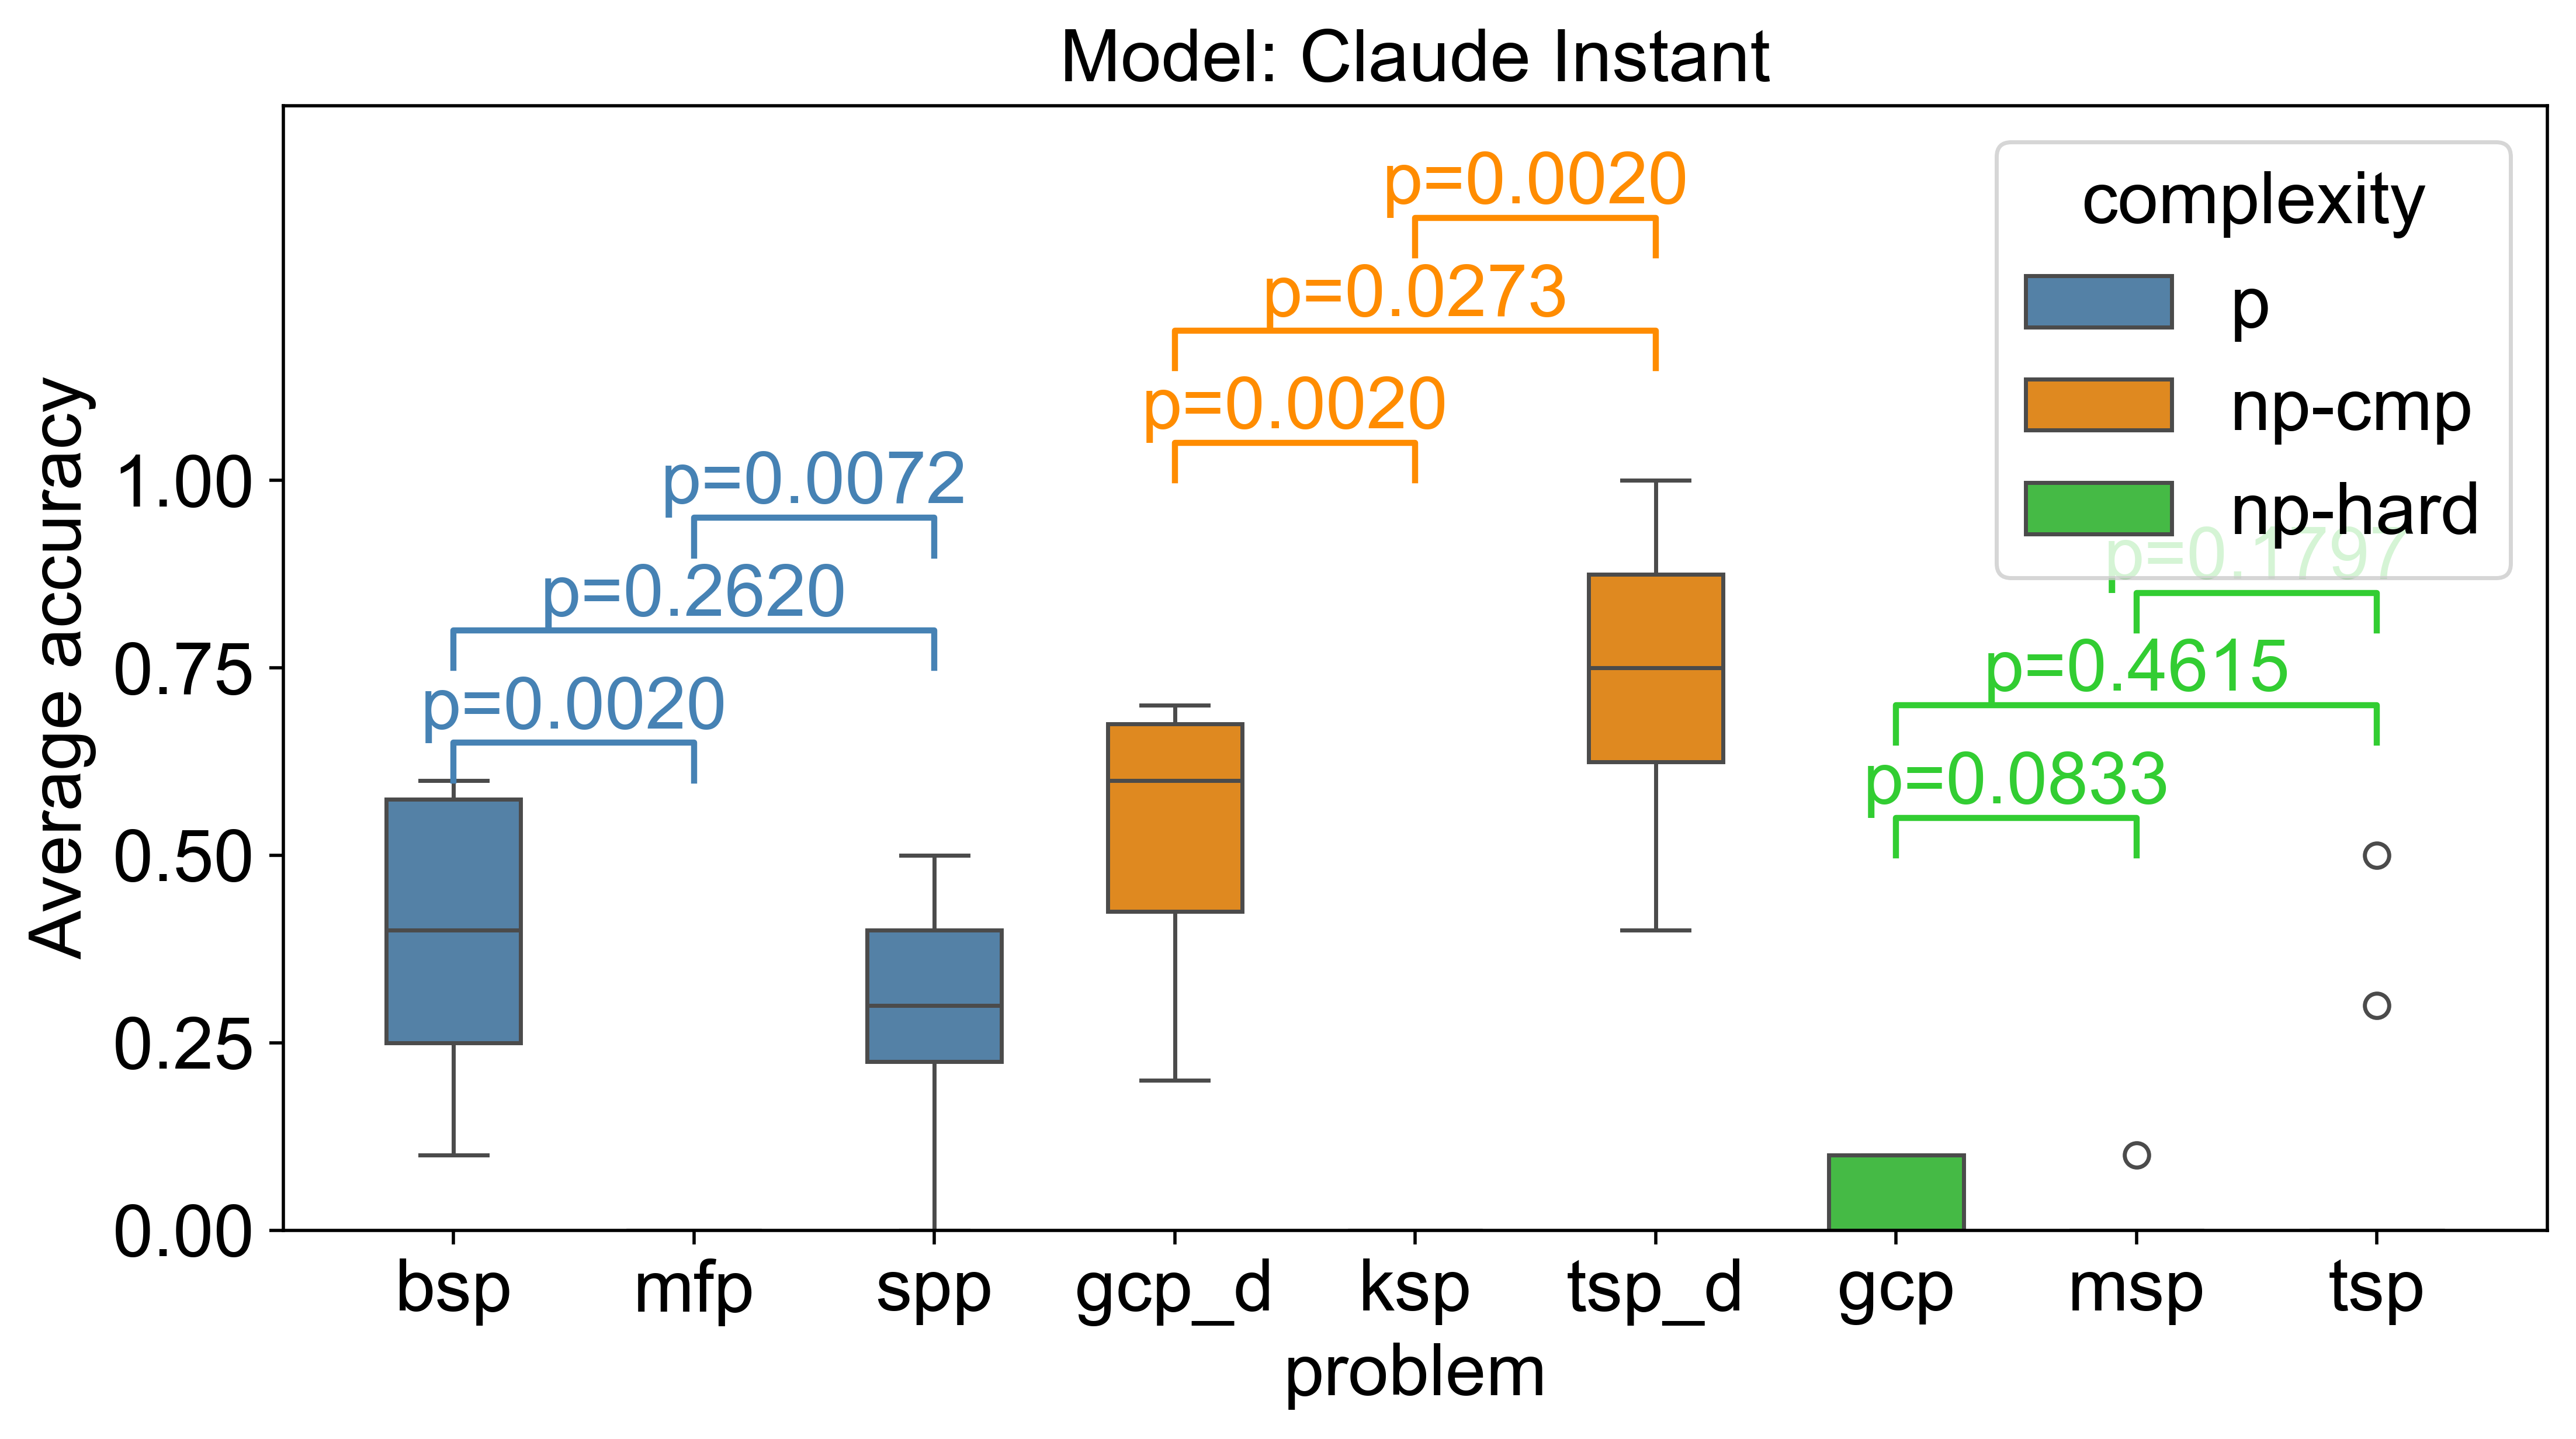

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

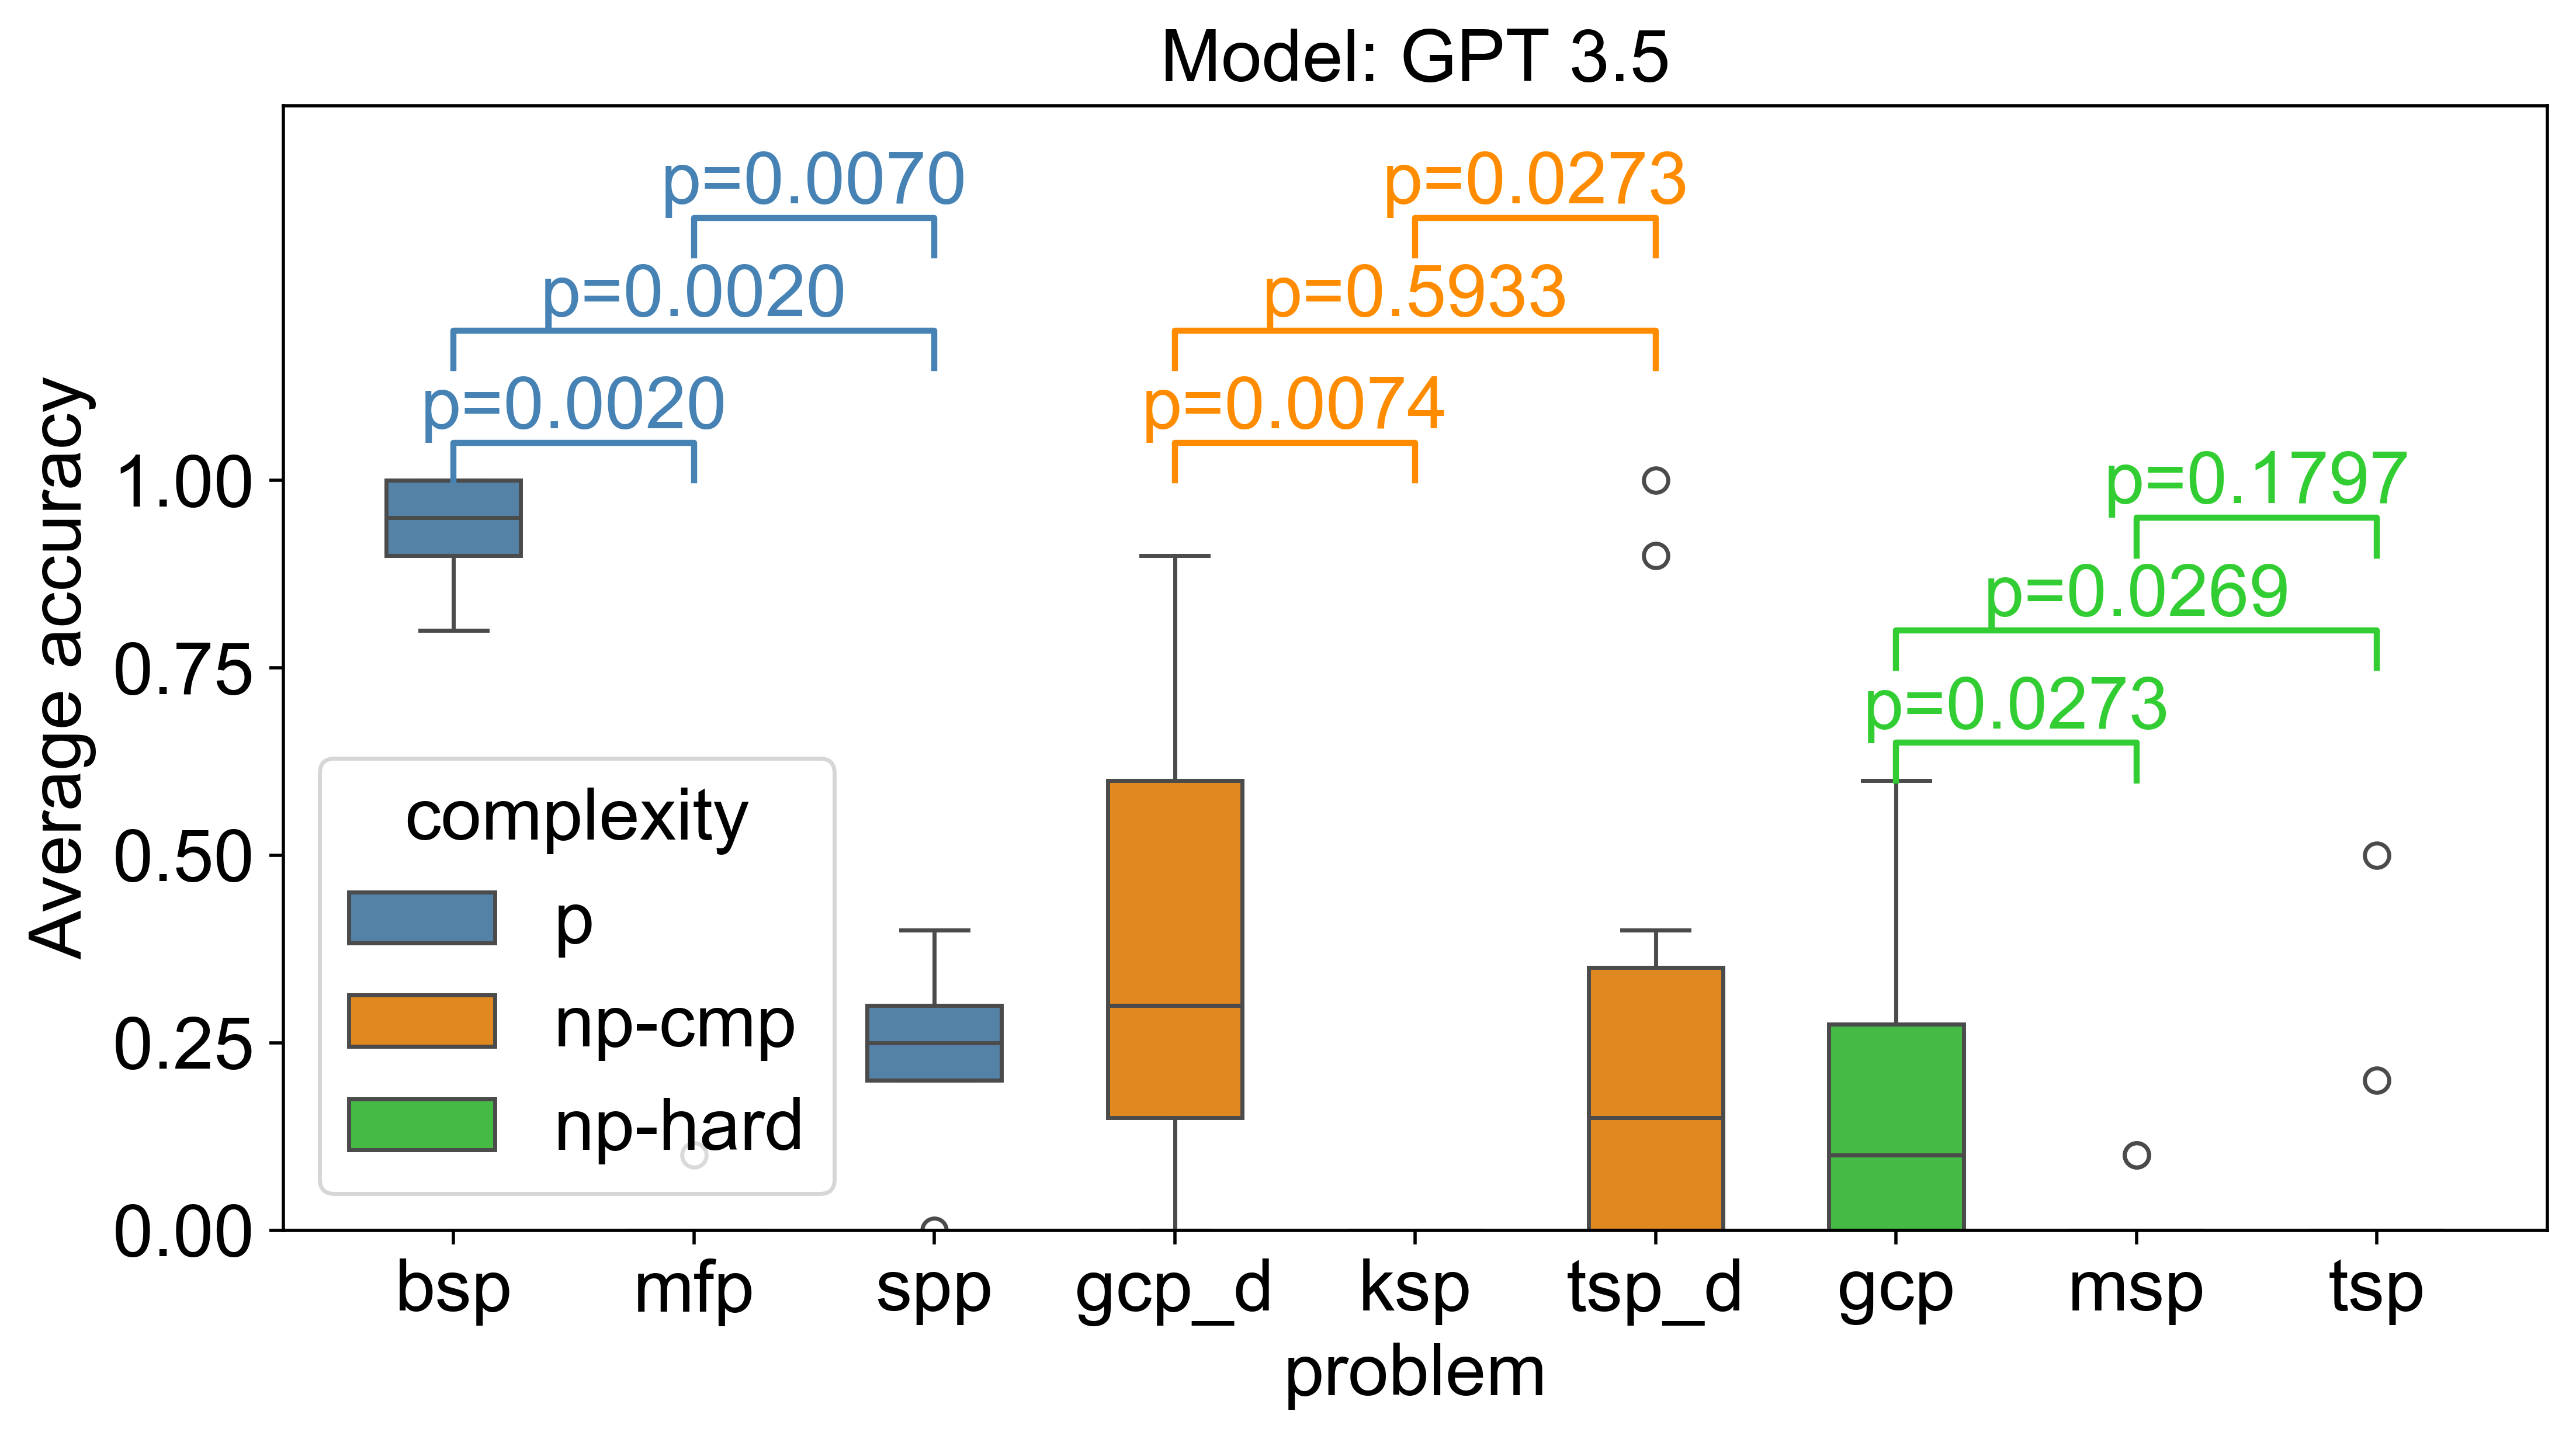

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there ar

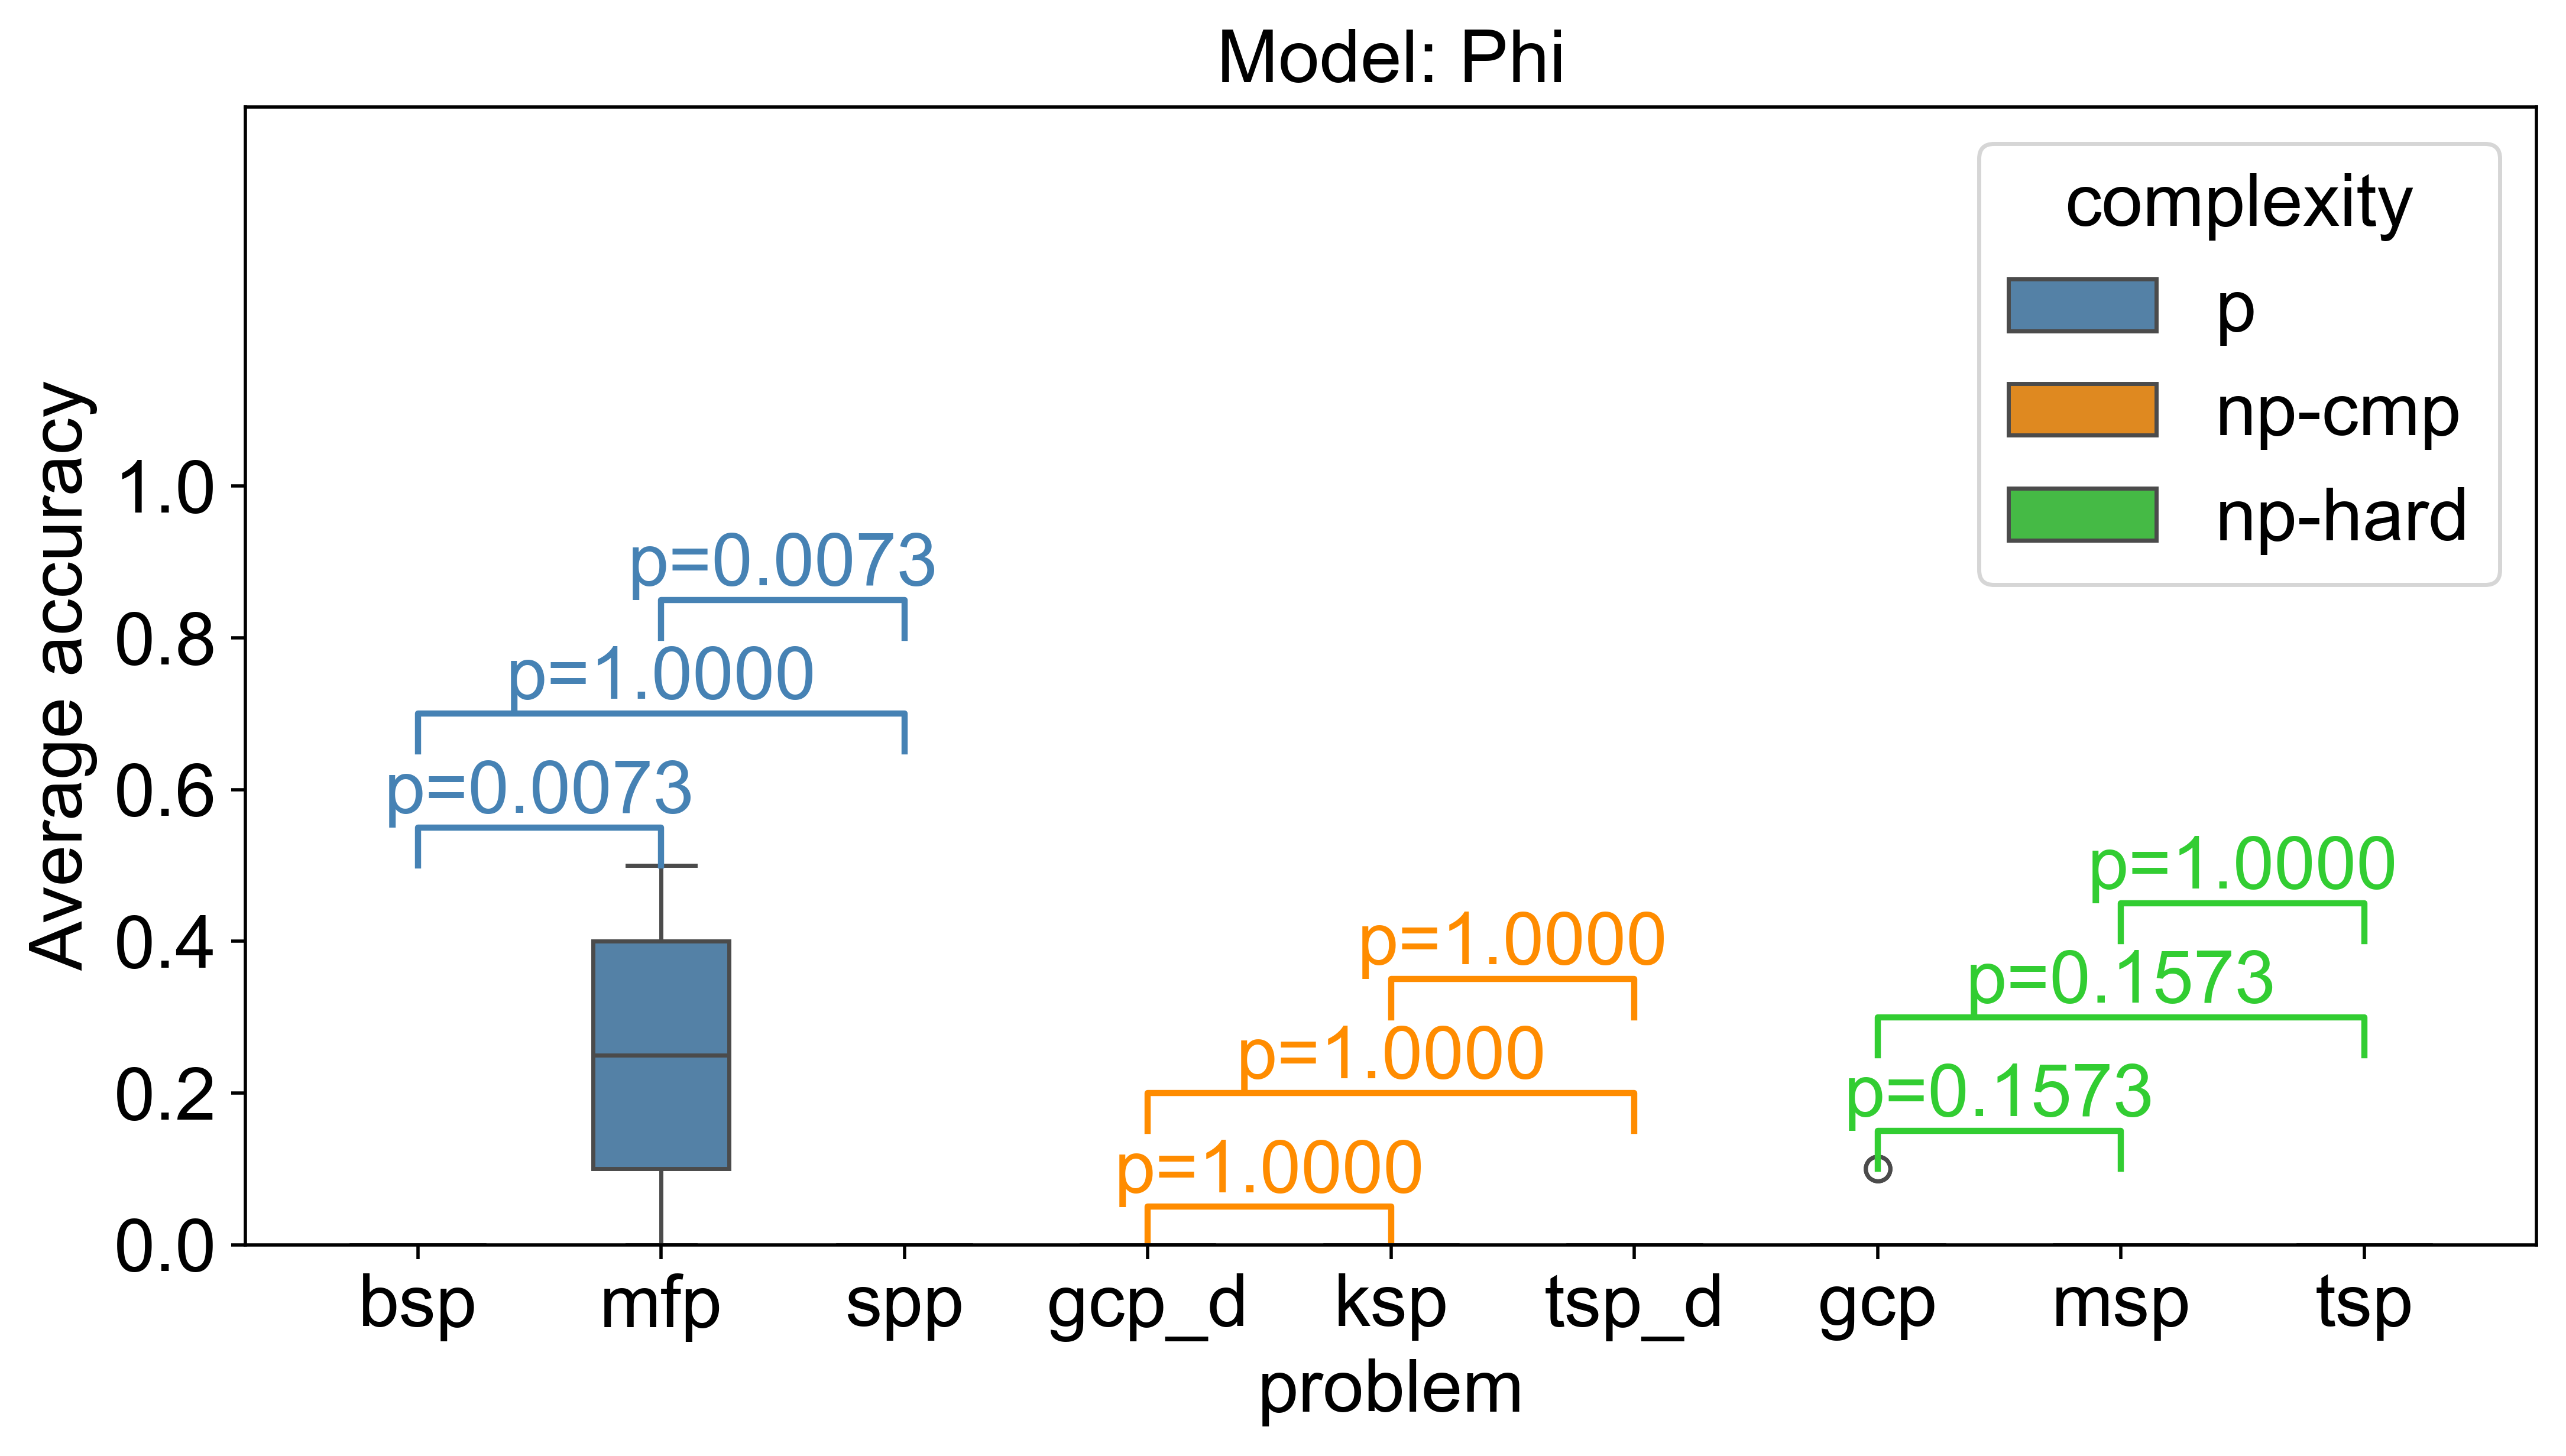

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

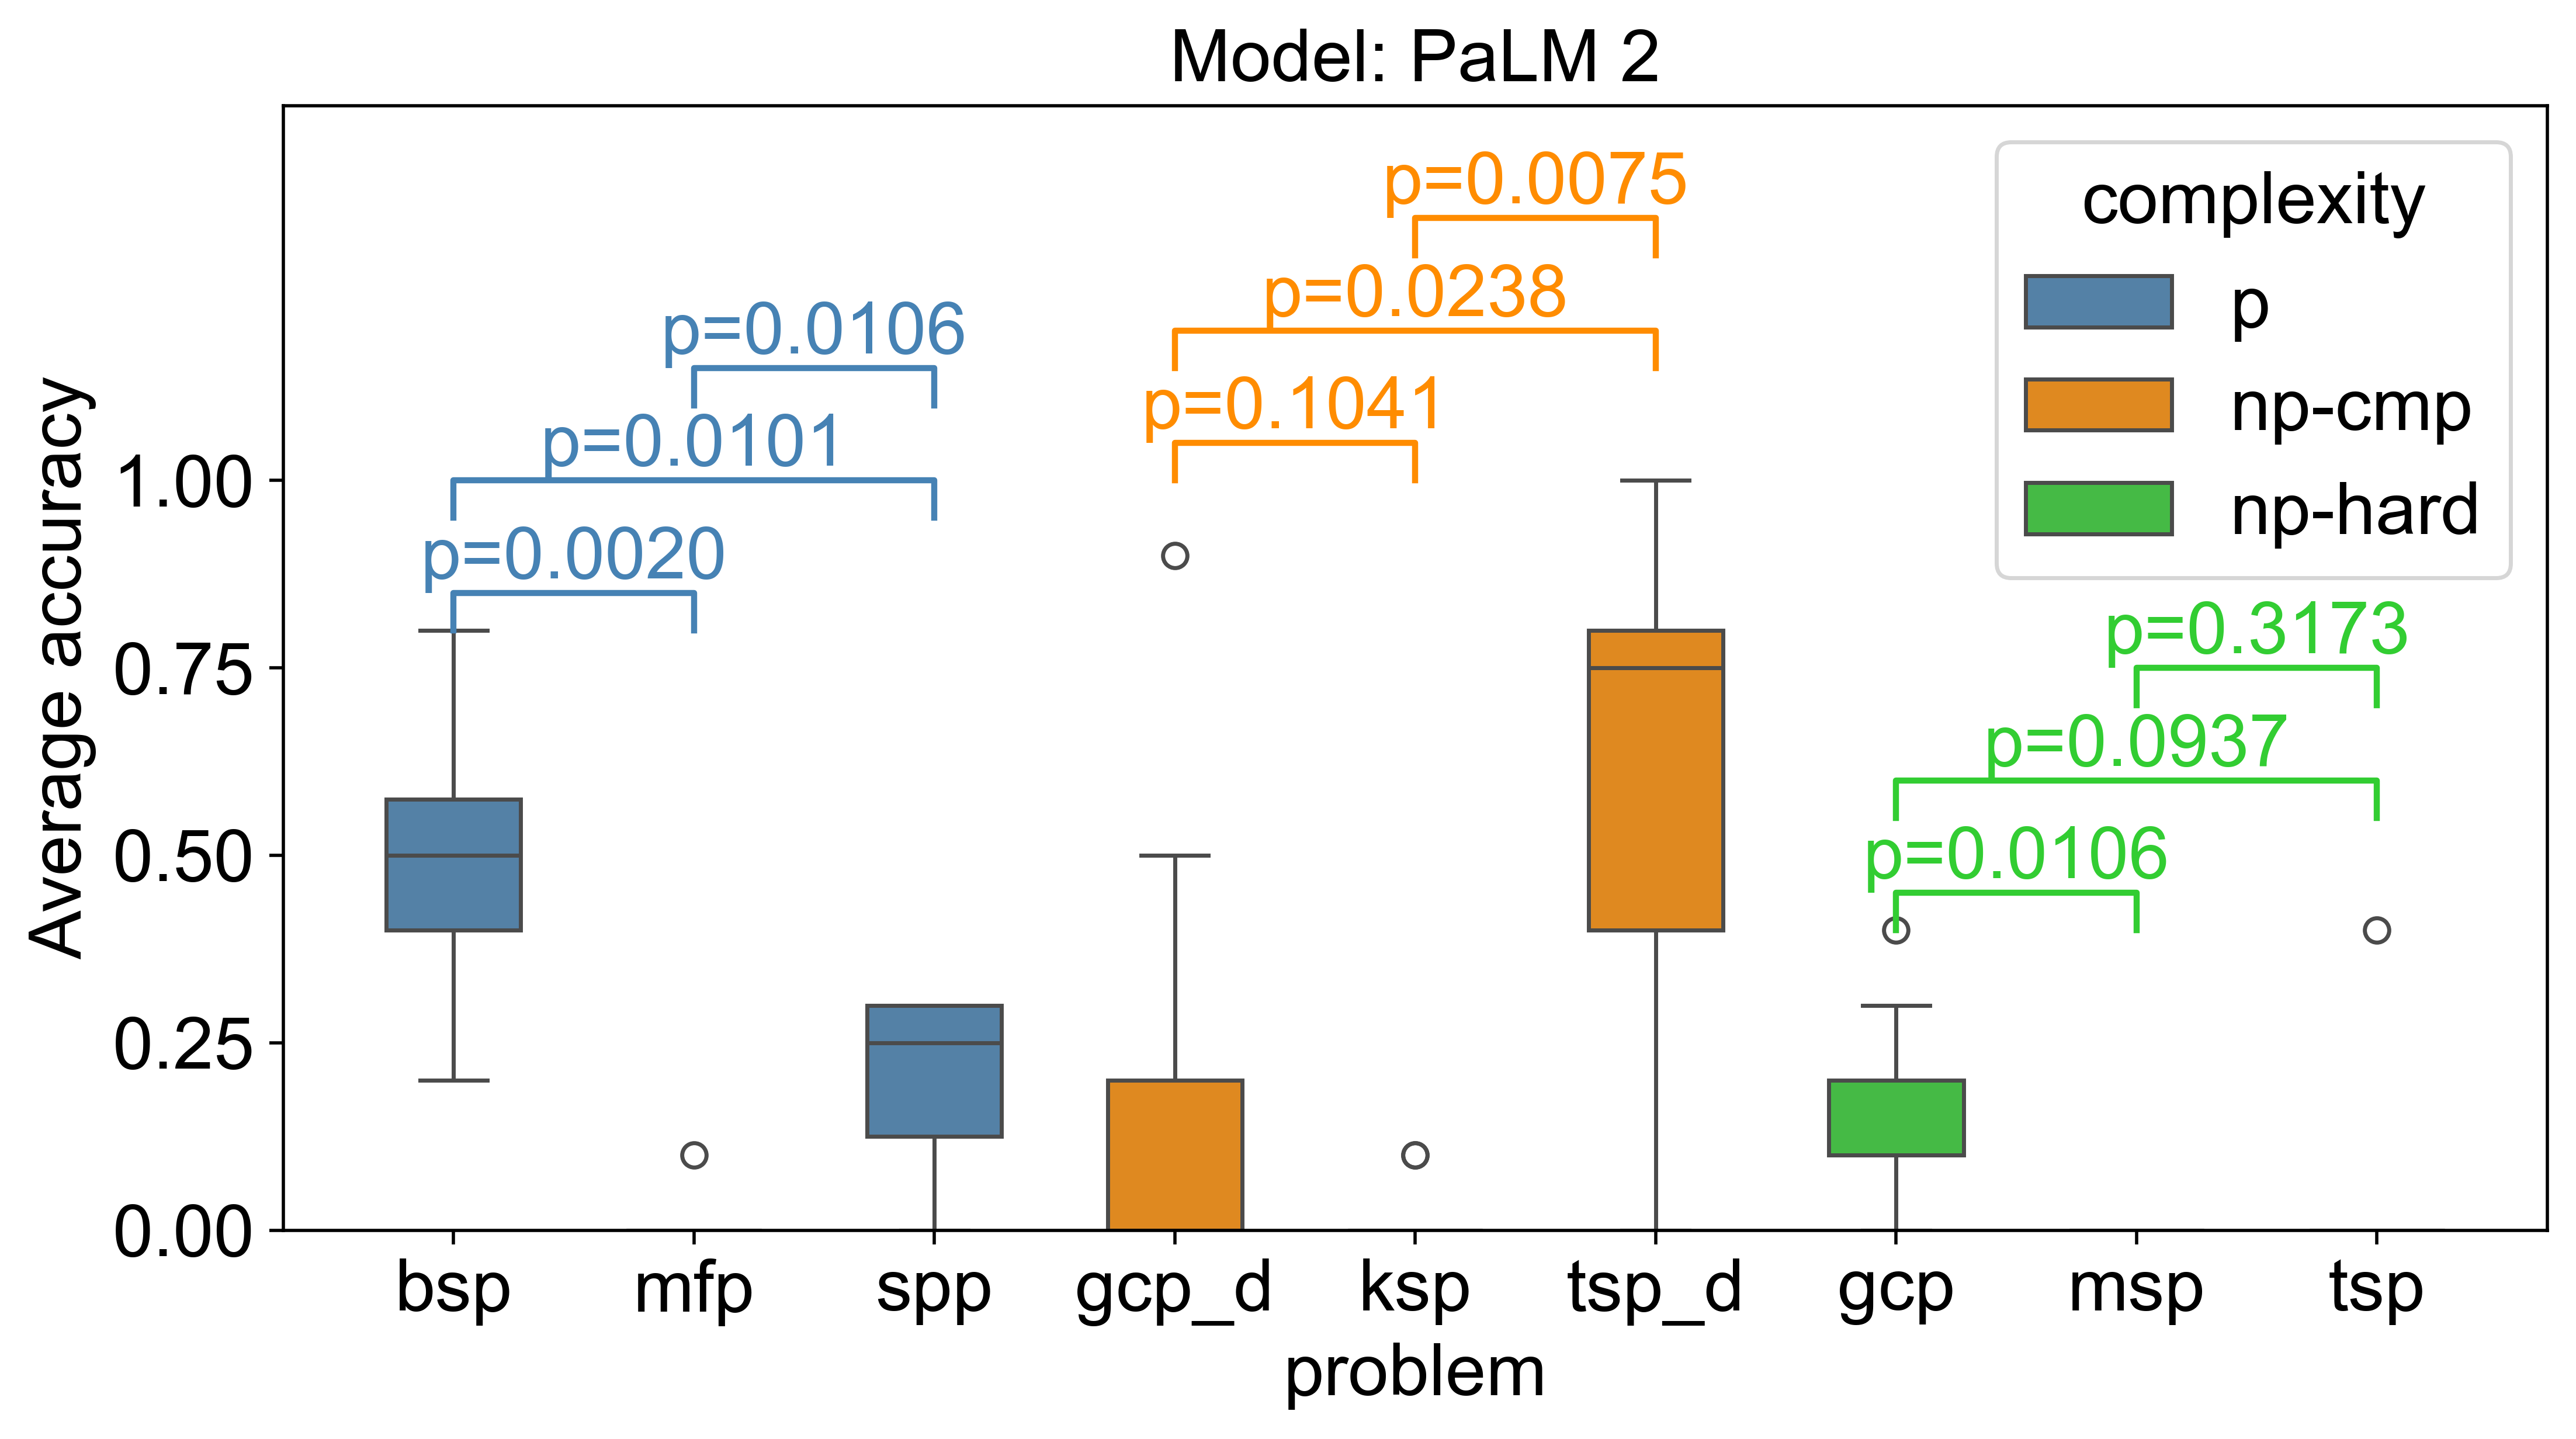

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

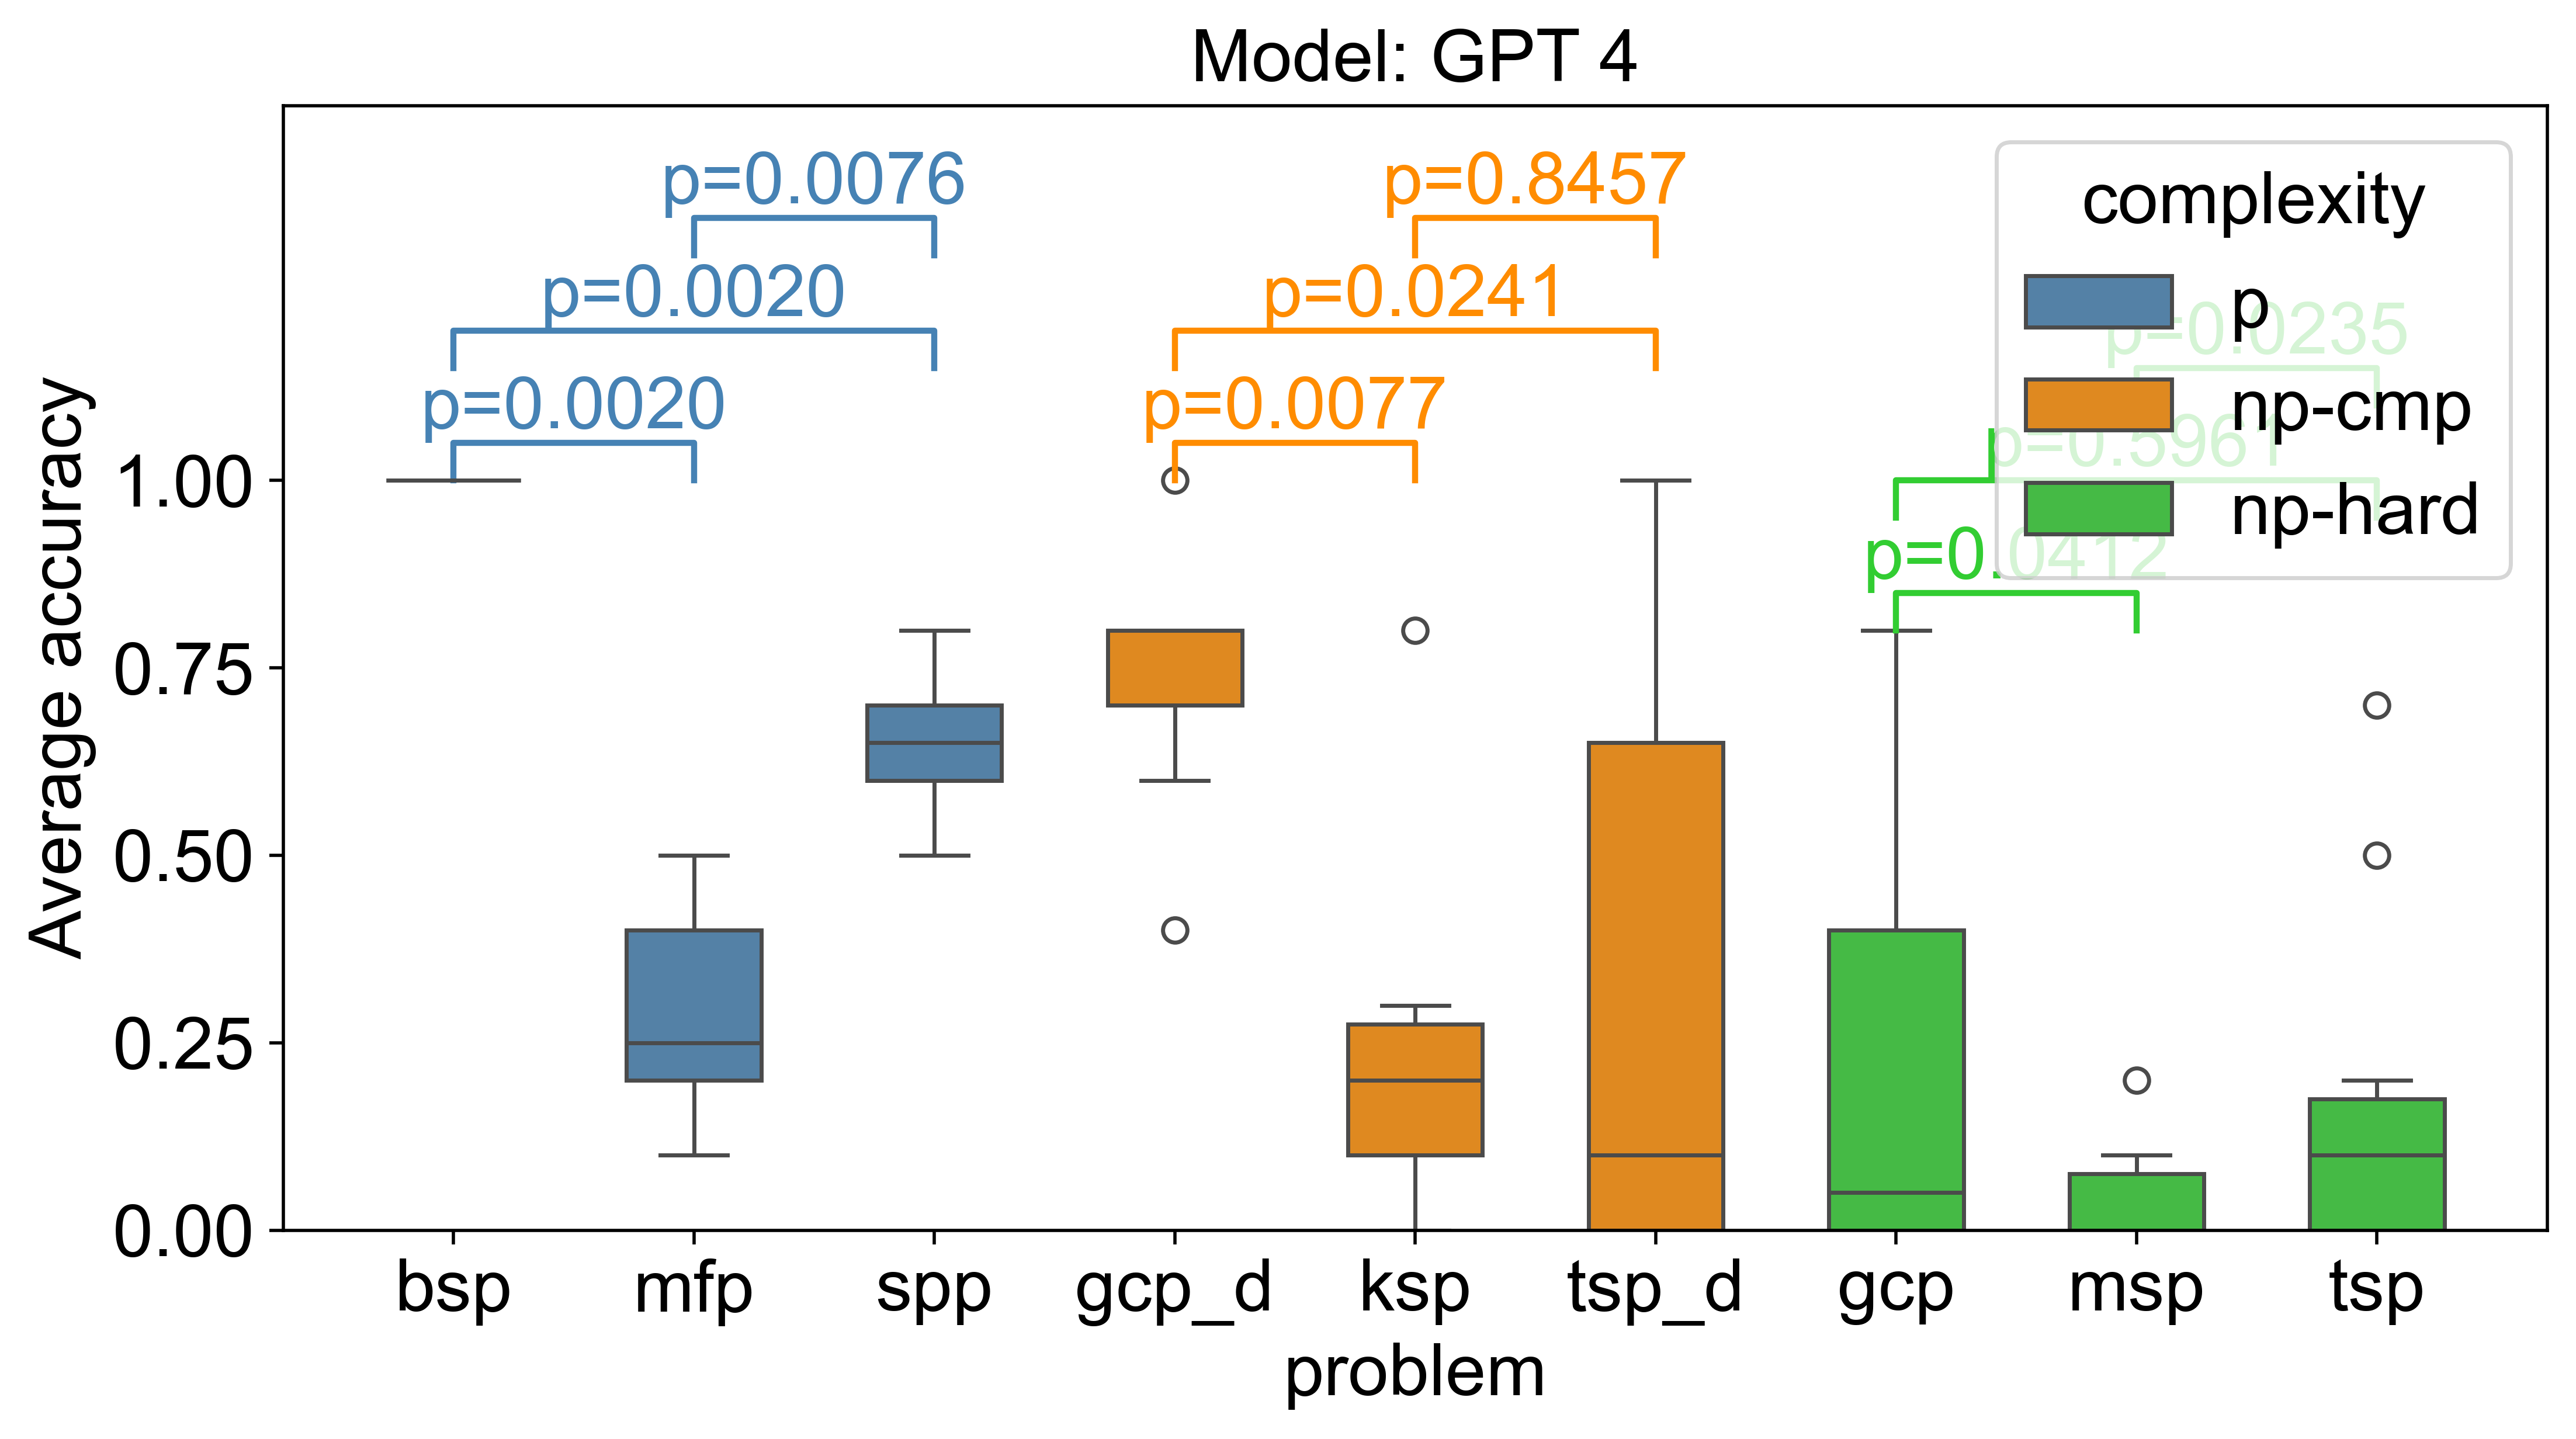

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  w

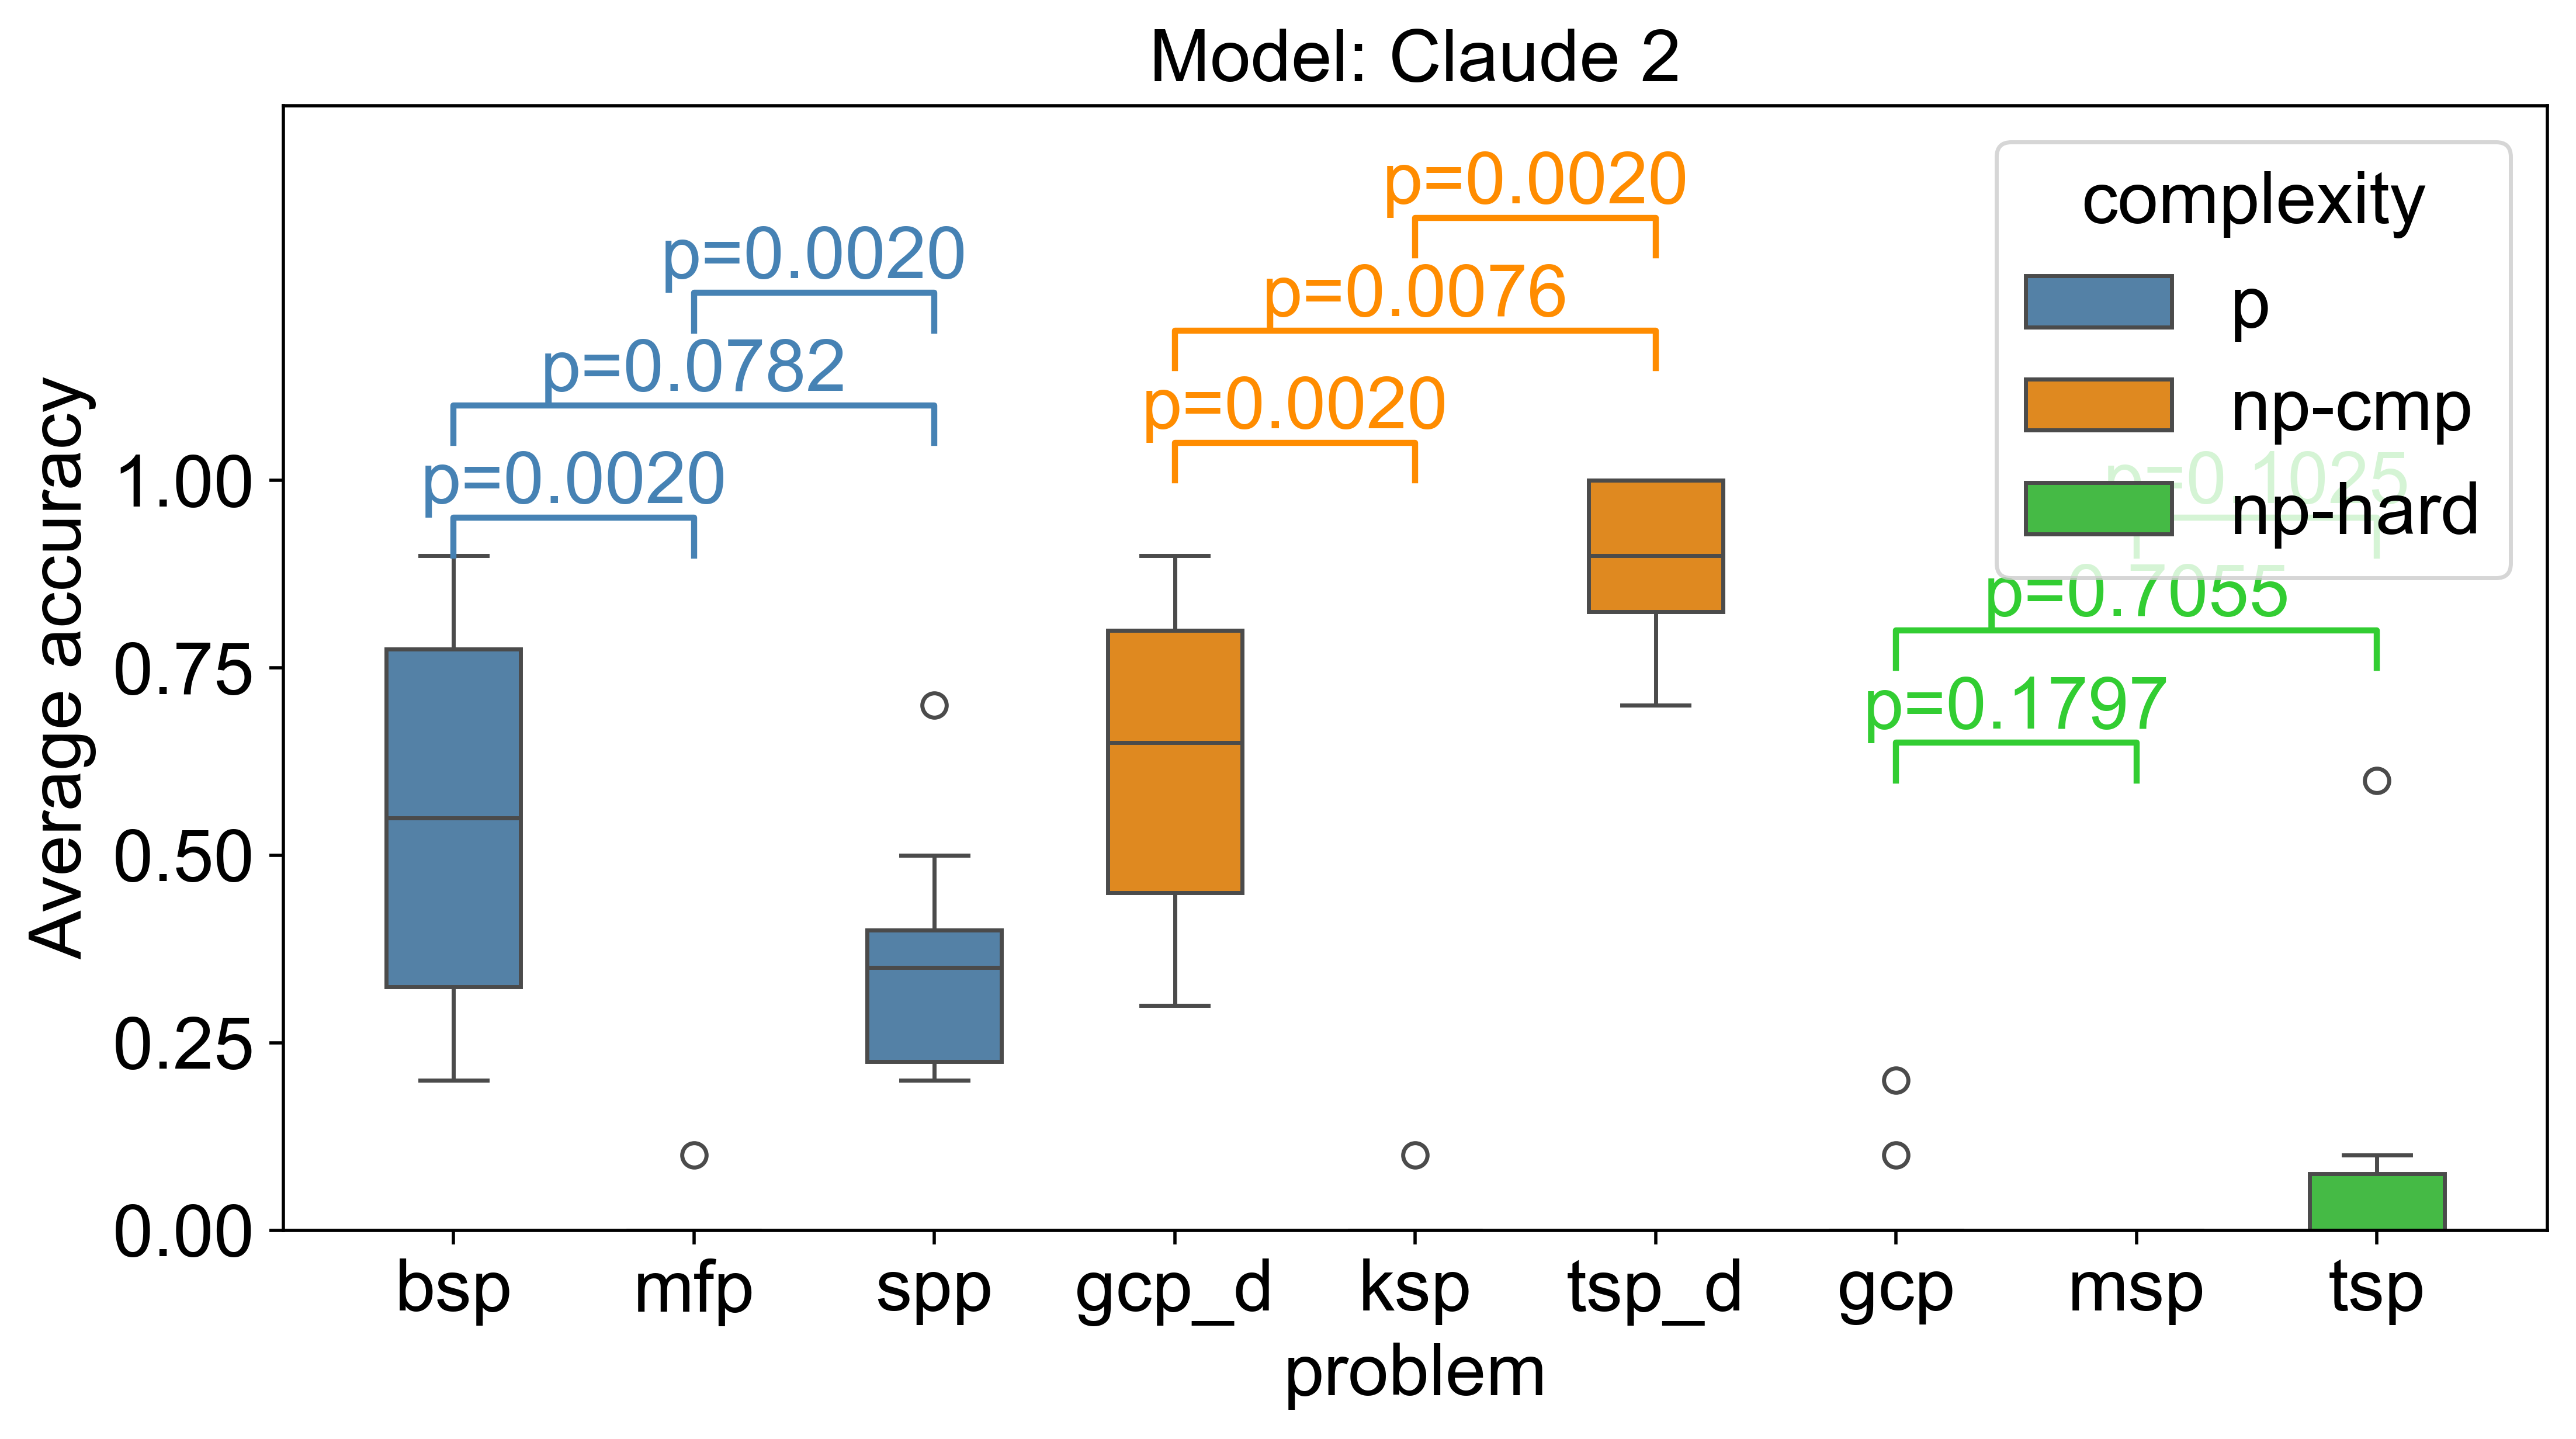

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there ar

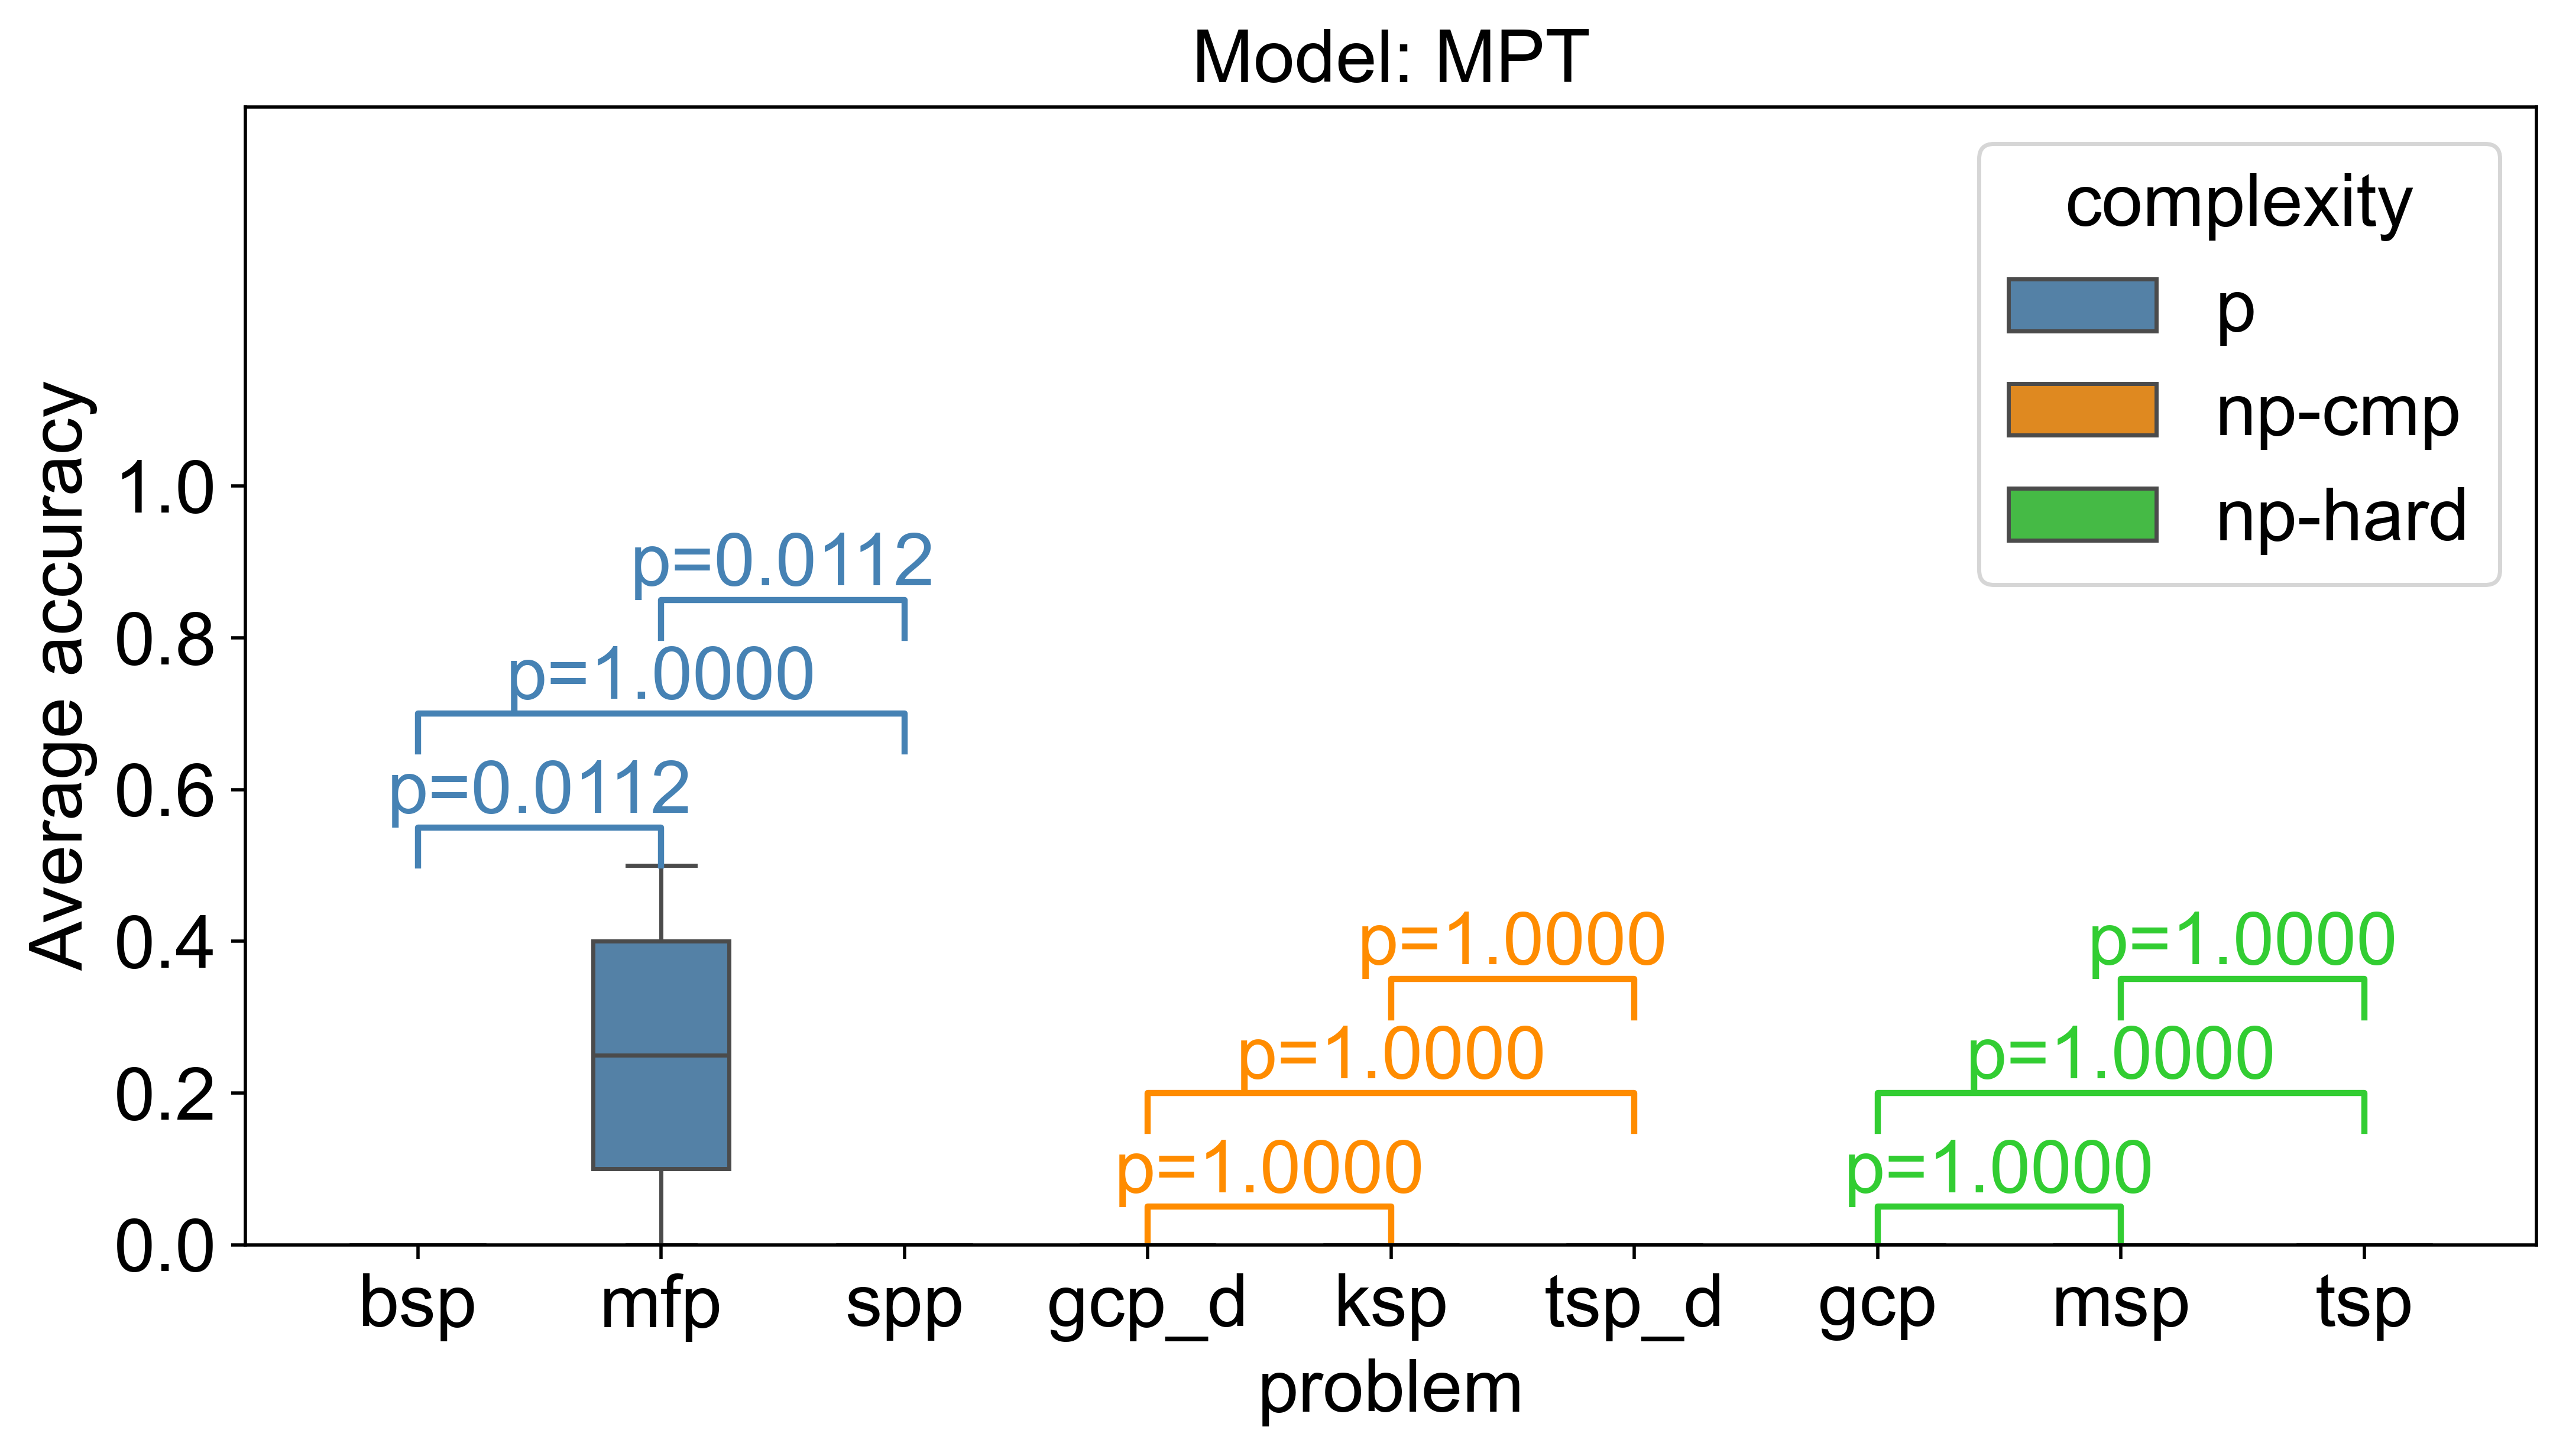

In [23]:
models = df['model'].unique()
for model in models:
    create_figure(model_df, model)